project name: flexpart_management
created by diego aliaga daliaga_at_chacaltaya.edu.bo

imports

In [26]:

from useful_scit.imps import *
# noinspection PyUnresolvedReferences
import matplotlib.colors
import flexpart_management.modules.FlexLogPol as FlexLogPol
import flexpart_management.modules.constants as co
# noinspection PyUnresolvedReferences
import flexpart_management.modules.flx_array as fa

In [27]:
import flexpart_management.modules.clustering_funs as cfuns

ucp.set_dpi( 300 )
CONC_Q = 'conc_q'

plt.style.use( 'seaborn-whitegrid' )
plt.rcParams[ 'figure.facecolor' ] = 'white'

Q_ATTR = 'unit quantile normalized SRR'
CONC_DET_ATTR = 'Diurnal variation of SSR [%]'

In [28]:

def get_cluster_diurnal_var( ds , clus_n , conc_lab , N_CLUSTERS ,
                             short_name ) :
    # %%

    da_ = ds[ conc_lab ]
    da_: xr.DataArray = da_.where( ds[ co.LAB ] == clus_n )
    # da=da.dropna(co.ZM,how='all')
    # da=da.dropna(co.TH_CENTER,how='all')
    # da=da.dropna(co.R_CENTER,how='all')
    da_ = da_.sum( [ co.R_CENTER , co.TH_CENTER , co.ZM ] )
    da_.load()
    # %%
    da = da_.copy()
    from scipy.signal import savgol_filter
    sf = savgol_filter( da , 25 , 1 )
    con_sg = 'con_sg'
    da = da.to_dataset()
    da[ con_sg ] = da[ conc_lab ].copy()
    da[ con_sg ].values = sf
    con_det = 'conc_detrended'
    da[ con_det ] = da[ conc_lab ] - da[ con_sg ]
    # %%
    # %%
    local_time = 'local_time'
    da = da.assign_coords(
        **{ local_time : da[ co.RL ] - pd.Timedelta( hours=4 ) } )
    da = da.swap_dims( { co.RL : local_time } )
    # %%
    time_ = da[ local_time ] - pd.Timedelta( hours=11.9 )
    time_ = time_.dt.round( 'D' )
    day = 'day'
    da = da.assign_coords( **{ day : time_ } )
    hour = 'local time [hour]'
    da = da.assign_coords( **{ hour : da[ local_time ].dt.hour } )
    da = da.swap_dims( { local_time : hour } )
    # %%
    # da_sum = da.sum(fa.get_dims_complement(da,hour))
    # da_sum.load()
    # %%
    dg = da.groupby( day )
    # dg
    # %%
    da_list = [ ]
    for l , d in dg :
        d: xr.DataArray
        dd = d.reset_coords( day , drop=True )
        dd = dd.expand_dims( **{ day : [ l ] } )
        da_list.append( dd )
    # %%
    # noinspection PyTypeChecker
    nda: xr.DataArray = xr.concat( da_list[ : ] , dim=day )
    # %%
    nda = nda.drop( [ co.RL , local_time ] )[ { day : slice( 1 , -1 ) } ]
    mean_day = nda[ con_det ].std( hour )
    mean_all = mean_day.mean( day )
    mean_thre = mean_all * .1
    _boo = mean_day > mean_thre
    nda = nda.where( _boo )
    ratio_filtered = _boo.to_dataframe()[ con_det ].value_counts()
    print( ratio_filtered )
    # nda = nda.dropna(day,how='all')
    # nda

    # mean_day.plot()
    # plt.axhline(mean_all)
    # plt.axhline(mean_thre)
    # plt.show()

    # %%
    # %%
    # nda[ con_det ][ { day : slice( 3 , 10 ) } ].plot.line( x=hour )
    # plt.show()
    # %%
    conc_q = CONC_Q
    add_quantile_transform( con_det , conc_q , nda )
    # %%
    # noinspection PyTypeChecker
    f , axs = plt.subplots( 2 , 1 , sharex=True , sharey=False )
    axf = axs.flatten()
    ax0: plt.Axes = axf[ 0 ]
    mappable , ax = plot_conc_q_surface( conc_q , nda , ax=ax0 )

    _plot_lab = con_det
    ax1: plt.Axes = axf[ 1 ]
    plot_general_diurnal_var( nda , conc_lab , short_name , day , hour ,
                              _plot_lab , ax=ax1 )
    ax0.set_xlabel( None )
    ax1.set_title( None )
    ax0.set_title( short_name )
    ax0.set_axisbelow( False )
    ax0.grid( True , color='white' )

    # ax.set_yscale('log')
    # plt.show()
    f: plt.Figure
    f.colorbar( mappable , ax=ax0 , label=Q_ATTR )
    cbar = f.colorbar( mappable , ax=ax1 )
    cbar.ax.set_visible( False )
    # f.tight_layout()
    plt.show()
    label_key = 'labels'
    # %%
    # nda = clusterize( N_CLUSTERS , nda , conc_q , day , hour , label_key ,
    #                   conc_lab )
    # %%
    # plot_lab = conc_lab
    # plot_clusters( nda , _plot_lab , clus_n , day , label_key , short_name )
    # %%
    # %%
    # %%
    # %%


def plot_general_diurnal_var( nda , conc_lab , short_name , day , hour ,
                              _plot_lab , ax=None , q_min=.25 , q_max=.75 ) :
    if ax is None :
        f , ax = plt.subplots()
        ax: plt.Axes

    med_conc_lab = nda[ conc_lab ].mean( hour ).mean( day )
    # med_conc_lab = 0
    # _plot_lab = conc_lab
    # _plot_lab = conc_q
    plot_ops = { 'marker' : 'o' , 'ax' : ax }
    median = nda[ _plot_lab ].median( day ) + med_conc_lab
    qmin = nda[ _plot_lab ].quantile( q=q_min , dim=day ) + med_conc_lab
    # qmin.plot( **plot_ops , label=f'quantile: {q_min}' )
    qmax = nda[ _plot_lab ].quantile( q=q_max , dim=day ) + med_conc_lab
    # qmax.plot( **plot_ops , label=f'quantile: {q_max}' )
    # ax = plt.gca()
    lab = f'quantile {q_min}~{q_max}'
    ax.fill_between(x=qmin[hour],y1=qmin.values,y2=qmax.values,
                    alpha=.3,label=lab)
    median.plot( **plot_ops , label='median' )
    ax.set_title( short_name )
    ax.set_ylim( 0 , qmax.max() * 1.1 )
    ax.set_ylabel( CONC_DET_ATTR )
    ax.legend()
    # plt.show()
    return ax


def plot_conc_q_surface( conc_q , nda , ax=None ) :
    if ax is None :
        f , ax = plt.subplots()
    ax: plt.Axes
    nda[ conc_q ] = \
        nda[ conc_q ].assign_attrs( **{ 'long_name' : Q_ATTR } )
    # noinspection PyUnresolvedReferences
    mappable = \
        nda[ conc_q ].plot.pcolormesh(
            ax=ax , add_colorbar=False ,
            # cmap=plt.get_cmap( 'Reds' ),
            )
    return mappable , ax


def add_quantile_transform( con_det , conc_q , nda ) :
    from sklearn.preprocessing import QuantileTransformer
    scaler = QuantileTransformer()
    data_q = scaler.fit_transform( nda[ con_det ].values.T ).T
    nda[ conc_q ] = nda[ con_det ]
    nda[ conc_q ].values = data_q


def plot_clusters( nda , plot_lab , clust_n , day_key , label_key ,
                   short_name ) :
    g_ = nda.groupby( label_key )
    # %%
    # plot_lab = conc_q
    for l , d in g_ :
        vals = d[ plot_lab ]
        # vals = vals.where( vals > 1 , 1 )
        # vals = np.log10( vals )
        mean = vals.mean( day_key )
        # mean = 10 ** mean
        per = len( d[ plot_lab ] ) / len( nda[ plot_lab ] ) * 100
        per = int( np.round( per ) )
        label = f'lab:{l} | n:{len( d[ plot_lab ] )} | %:{per}'
        mean.plot( label=label )
    ax: plt.Axes = plt.gca()
    ax.legend()
    ax.set_xticks( range( 0 , 24 , 2 ) )
    ax.set_xticks( range( 0 , 24 , 1 ) , minor=True )
    ax.set_title( f'cluster name: {short_name}' )
    plt.show()


def clusterize( N_CLUSTERS , nda , conc_q , day , hour , label_key ,
                conc_lab ) :
    # %%
    from sklearn.cluster import KMeans
    weights = nda[ conc_lab ].sum( hour )
    kmeans = KMeans( n_clusters=N_CLUSTERS , random_state=0 )
    vals = nda[ conc_q ]
    vals = vals.where( ~vals.isnull() , 0 )
    labels = kmeans.fit_predict( vals ,
                                 sample_weight=weights
                                 )

    # %%
    df_lab = pd.DataFrame( labels , columns=[ label_key ] )
    df_lab[ 'count' ] = 1
    df_lab = df_lab.groupby( label_key ).count()
    df_lab = df_lab.sort_values( 'count' , ascending=False )
    df_lab = df_lab.reset_index()
    new_label = 'new_label'
    df_lab.index.name = new_label
    df_lab = df_lab.reset_index()
    df_lab = df_lab.set_index( label_key )

    relabel_dict = df_lab[ new_label ].to_dict()
    new_labels = [ relabel_dict[ l ] for l in labels ]
    # %%
    label_da = nda[ day ].copy()
    label_da.name = label_key
    label_da.values = new_labels
    # %%
    nda = nda.assign_coords( **{ label_key : label_da } )
    # %%
    return nda


def main() :
    # %%

    conc_lab = 'CONC'
    #     conc_lab = 'conc_smooth_p_t'
    N_CLUSTERS = 3
    ds = xr.open_mfdataset( [ co.latest_ds_mac ] , combine='by_coords' )
    conc_per = 'CONC_per'
    non_rl = [ co.ZM , co.R_CENTER , co.TH_CENTER ]
    ds[ conc_per ] = ds[ conc_lab ] / ds[ conc_lab ].sum( non_rl ) * 100
    csv_path = '/Users/diego/flexpart_management/' \
               'flexpart_management/tmp_data/prop_df_.csv'

    df = pd.read_csv( csv_path )

    # clus_n = 5

    # %%
    # %%
    for l , r in df.iterrows() :
        i = r[ 'cluster_i' ]
        short_name = r[ 'short_name' ]
        get_cluster_diurnal_var( ds , i , conc_per , N_CLUSTERS , short_name )

True     170
False      6
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


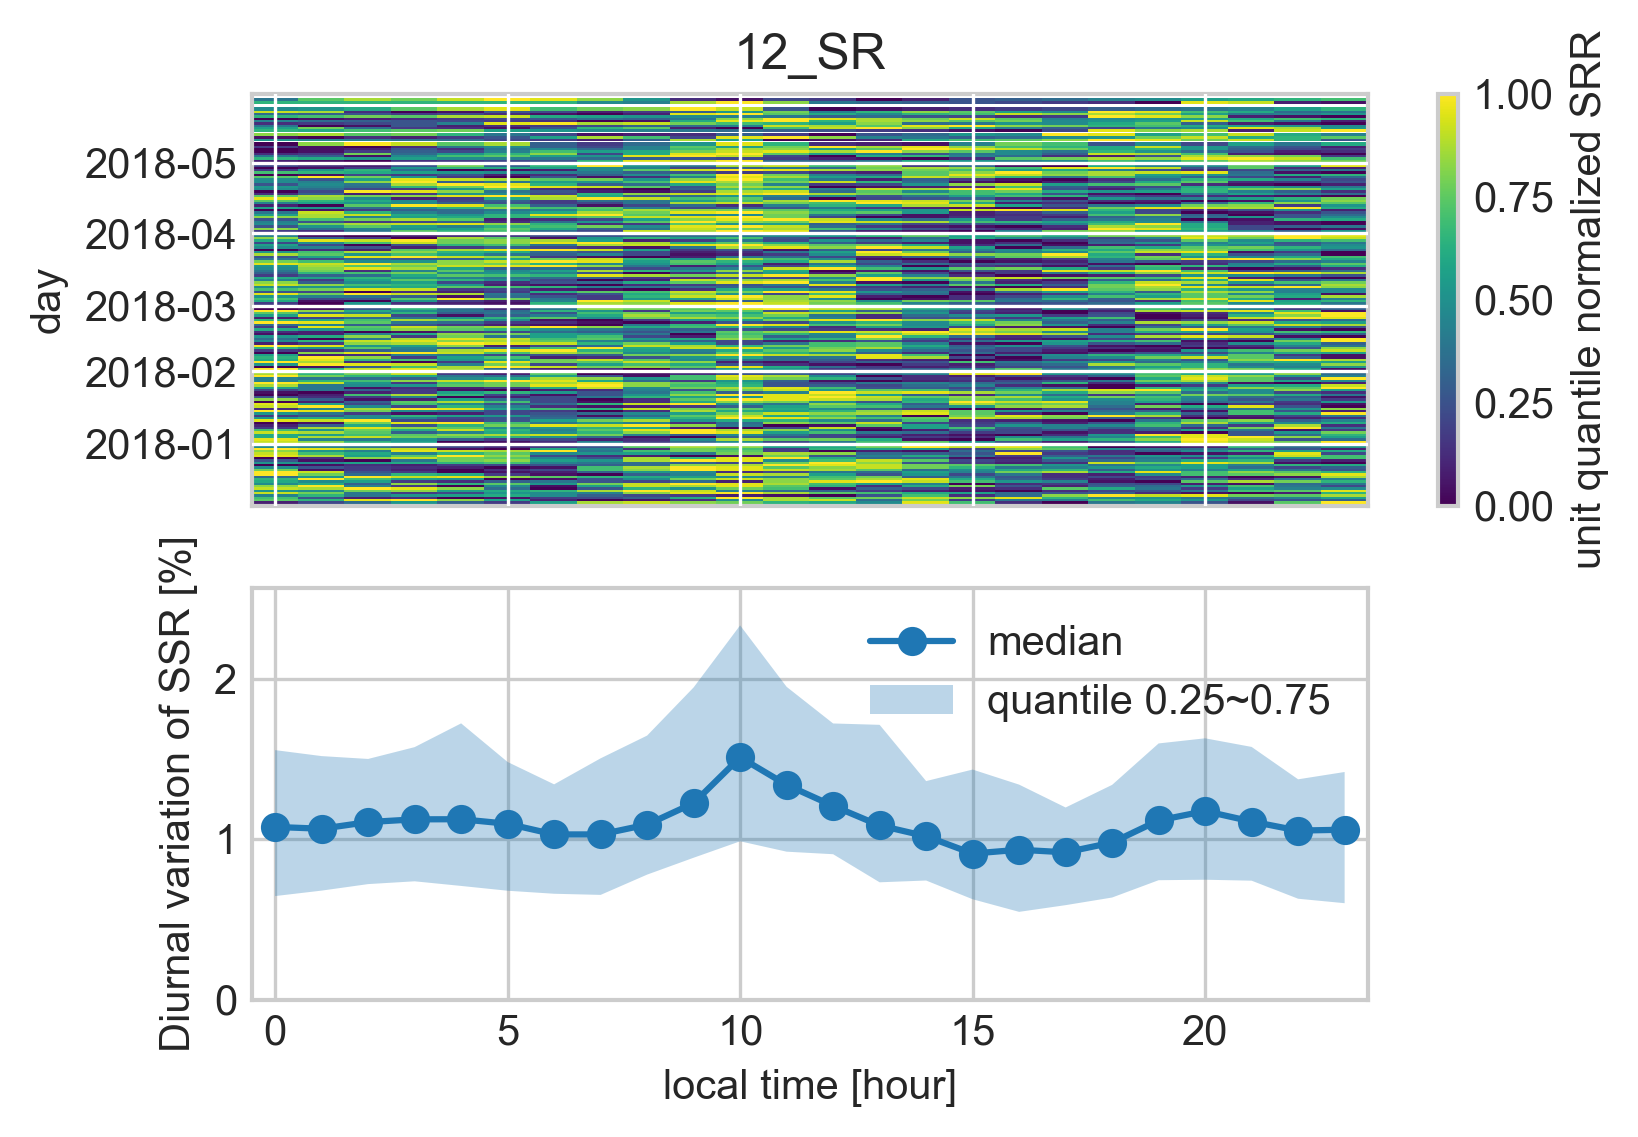

True     149
False     27
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


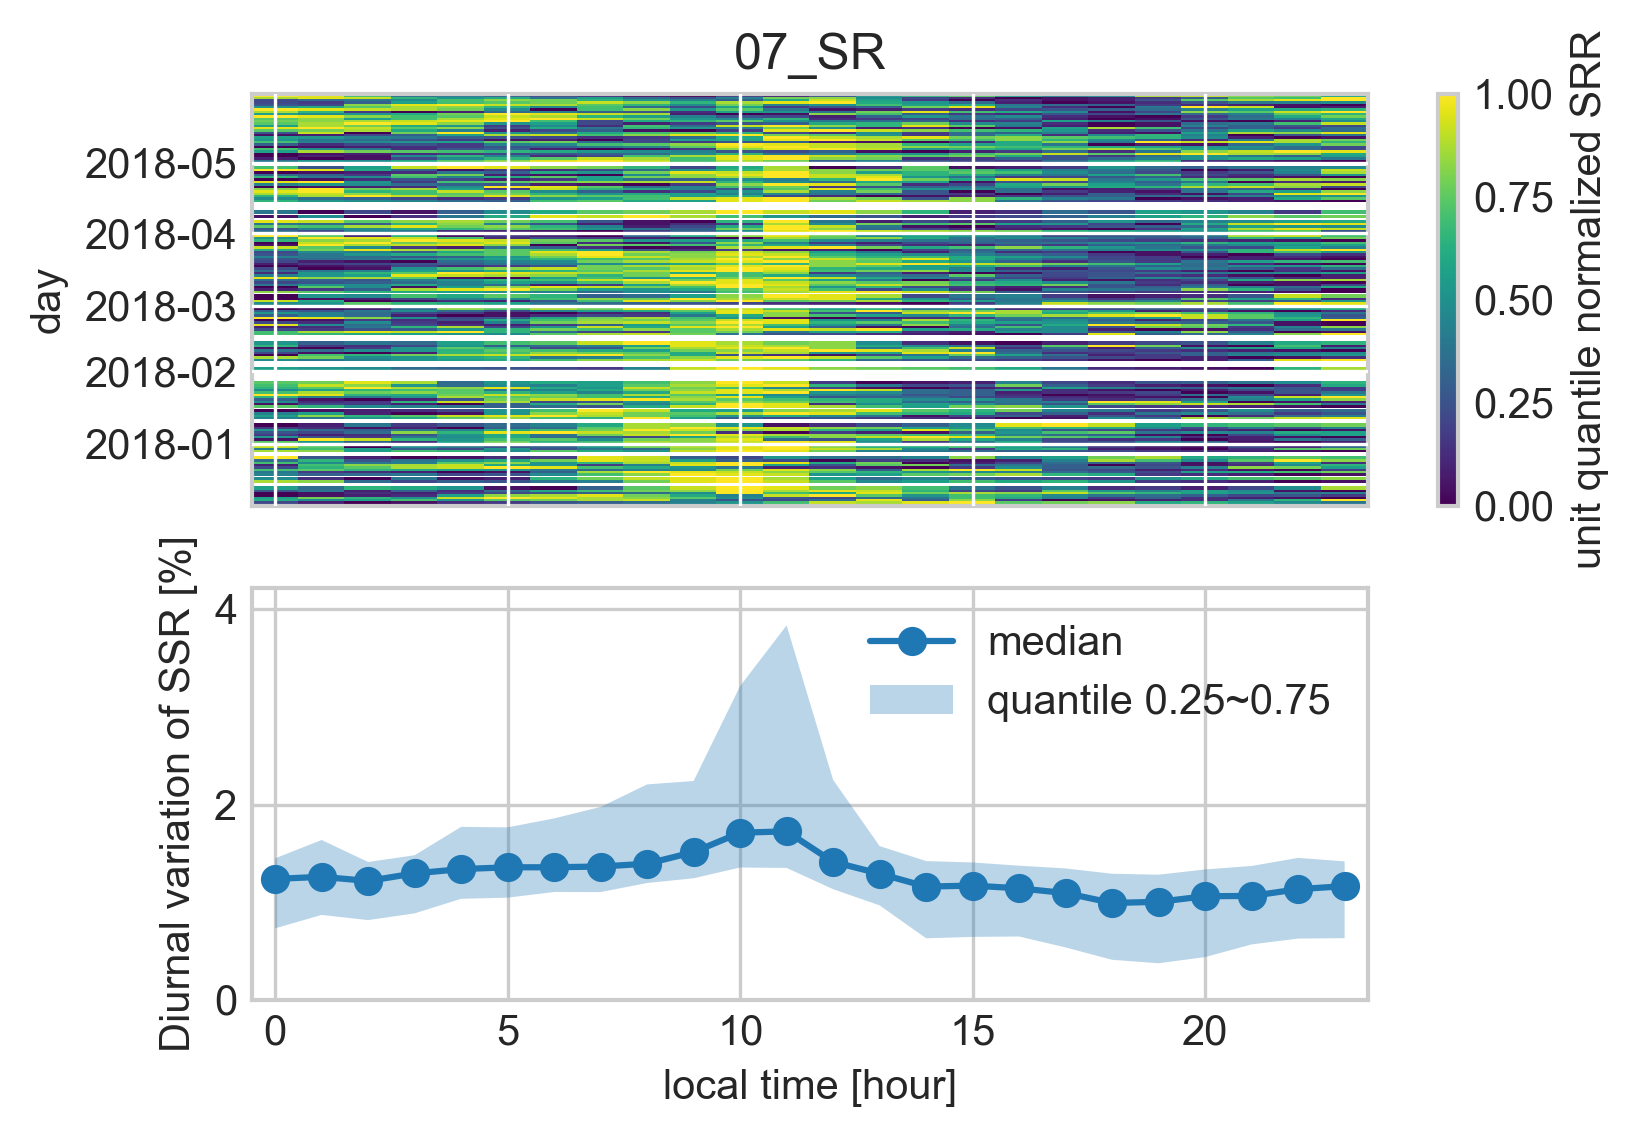

True     158
False     18
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


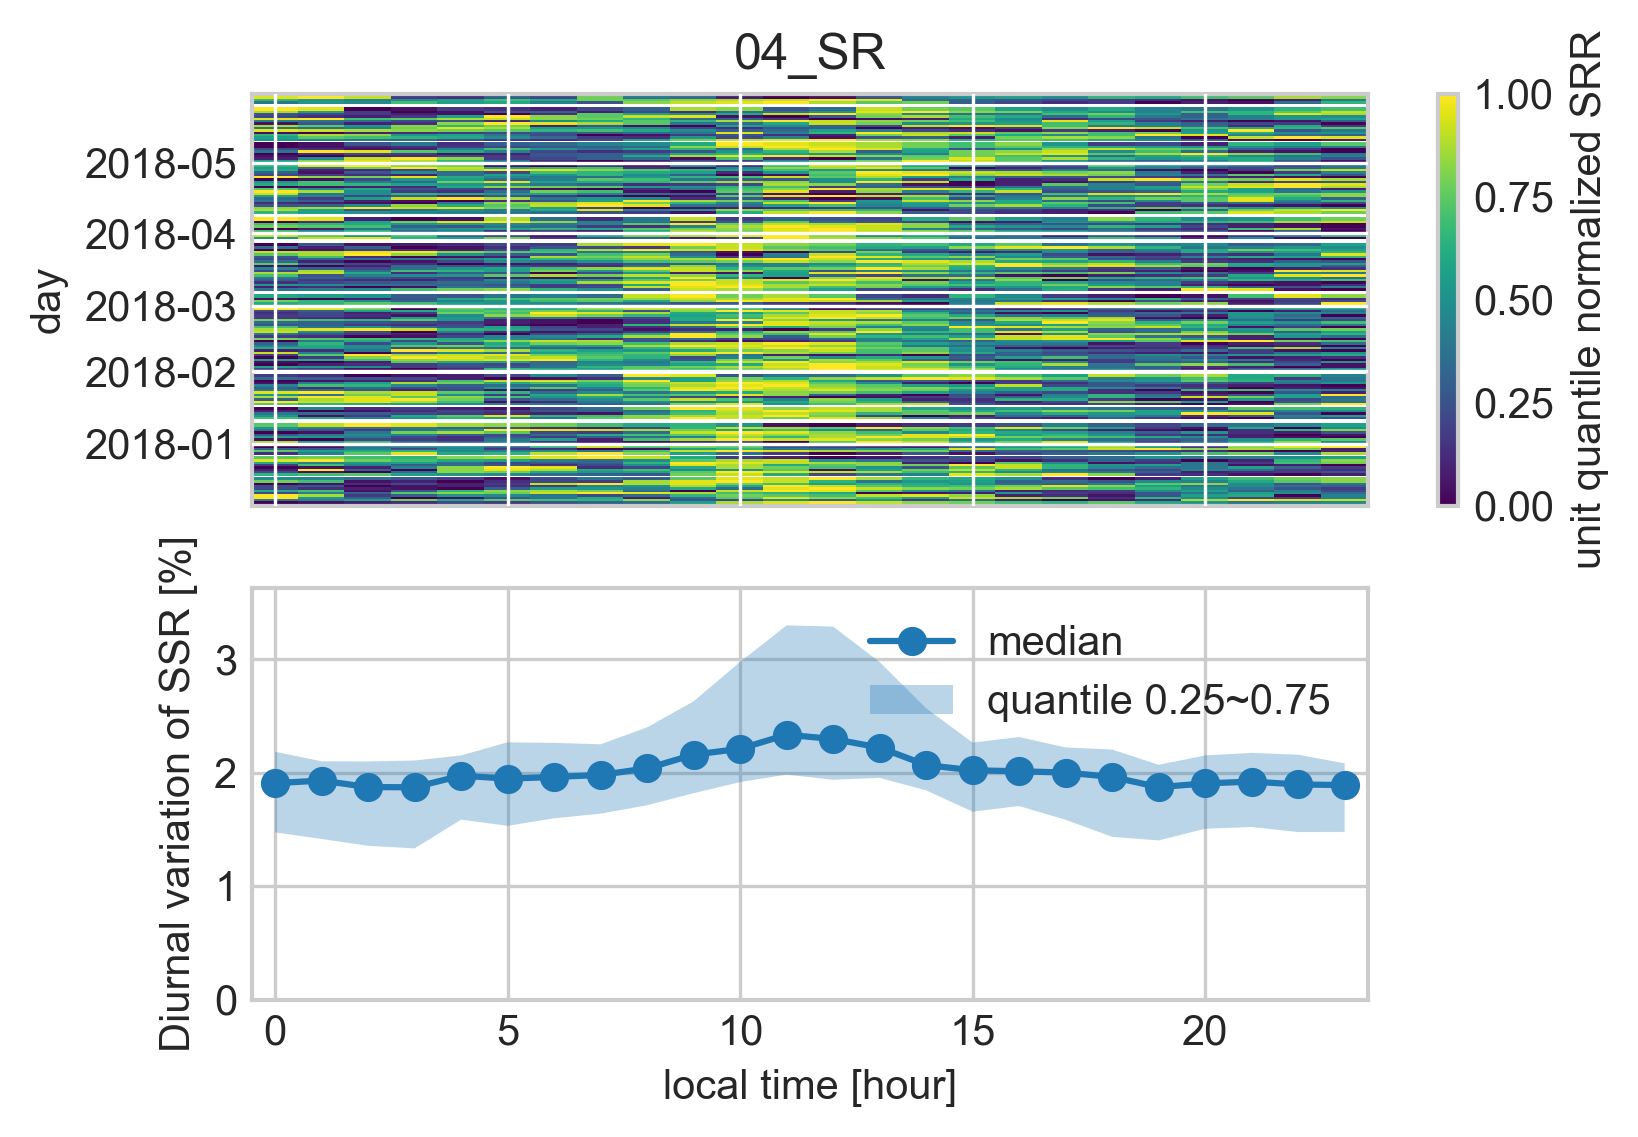

True     167
False      9
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


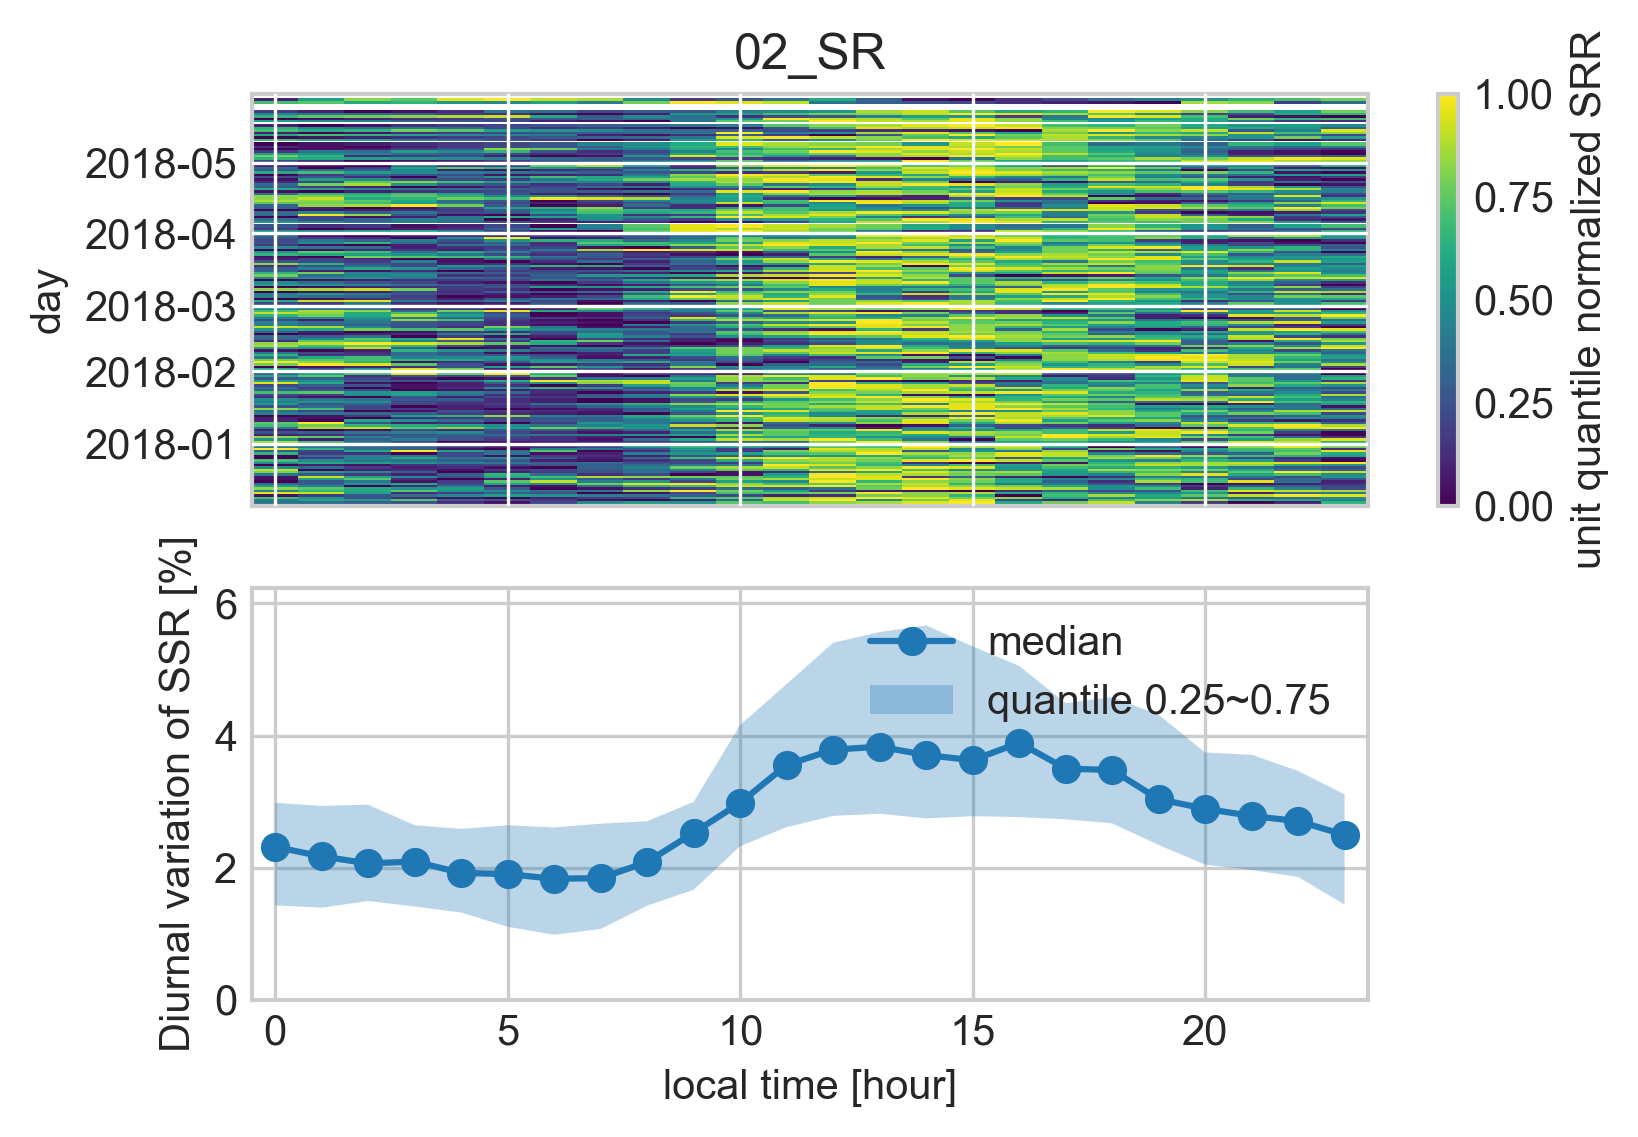

True     136
False     40
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


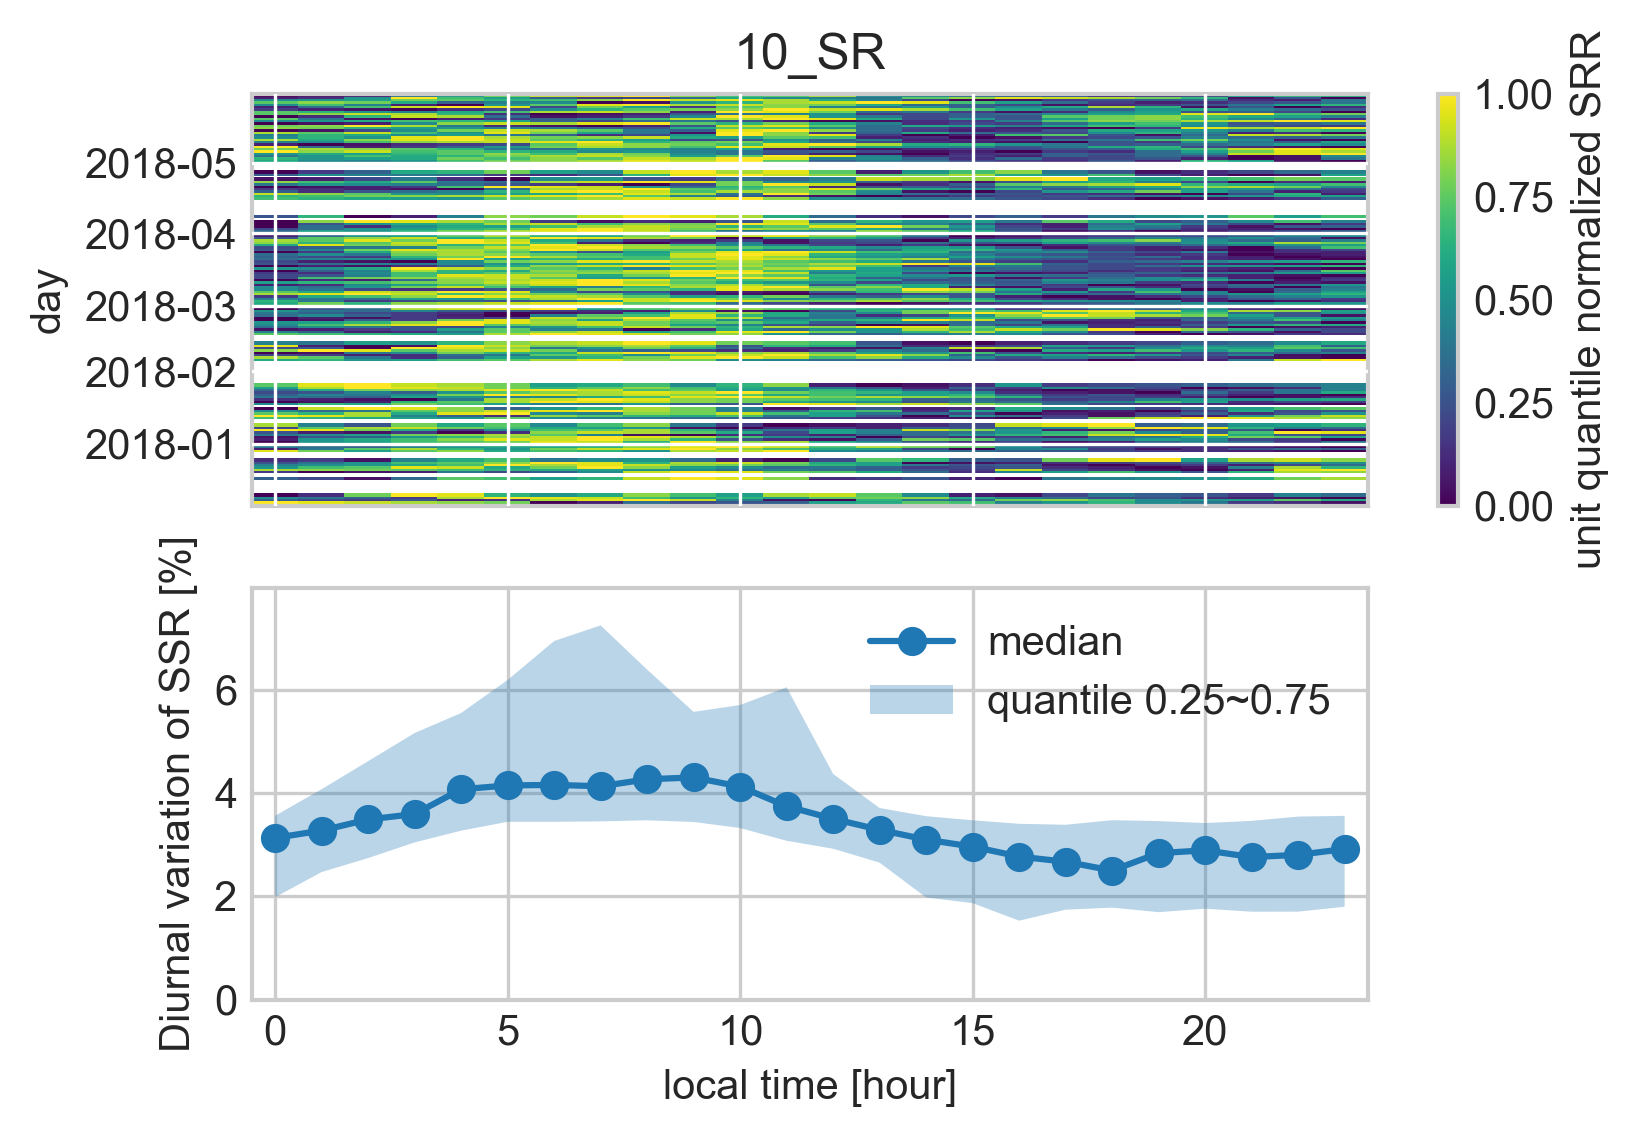

True     154
False     22
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


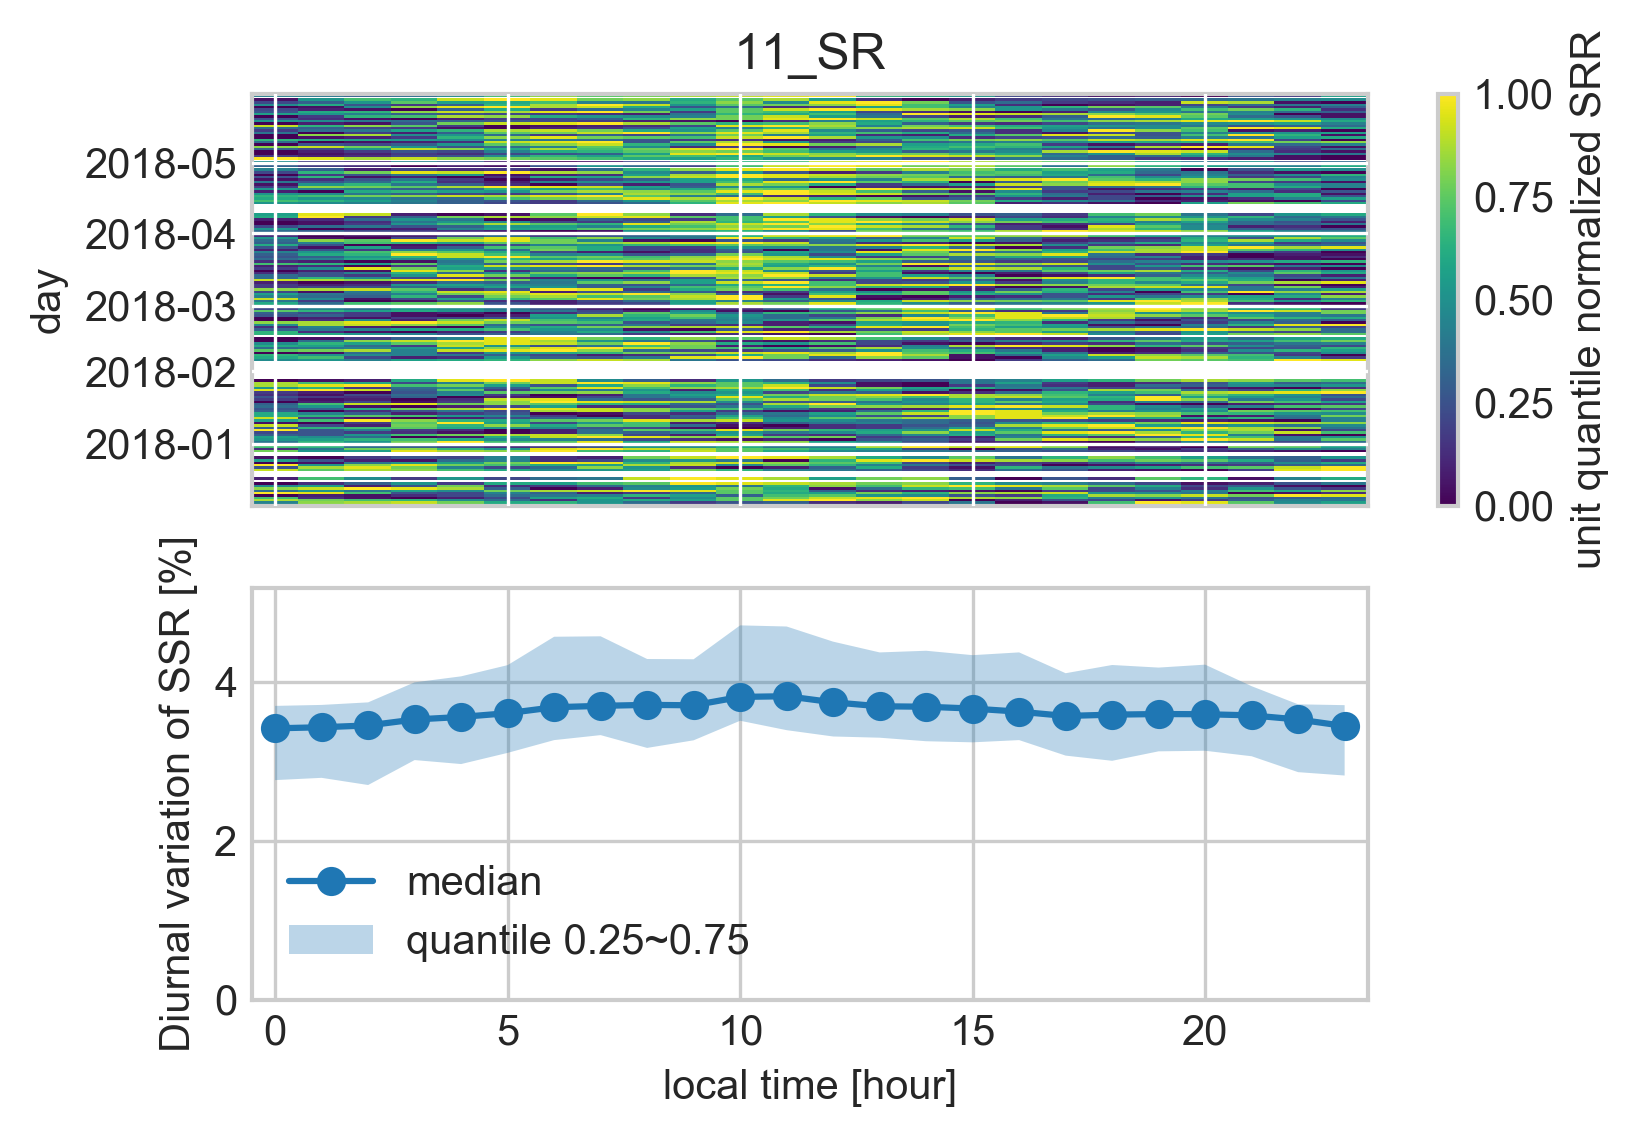

True     165
False     11
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


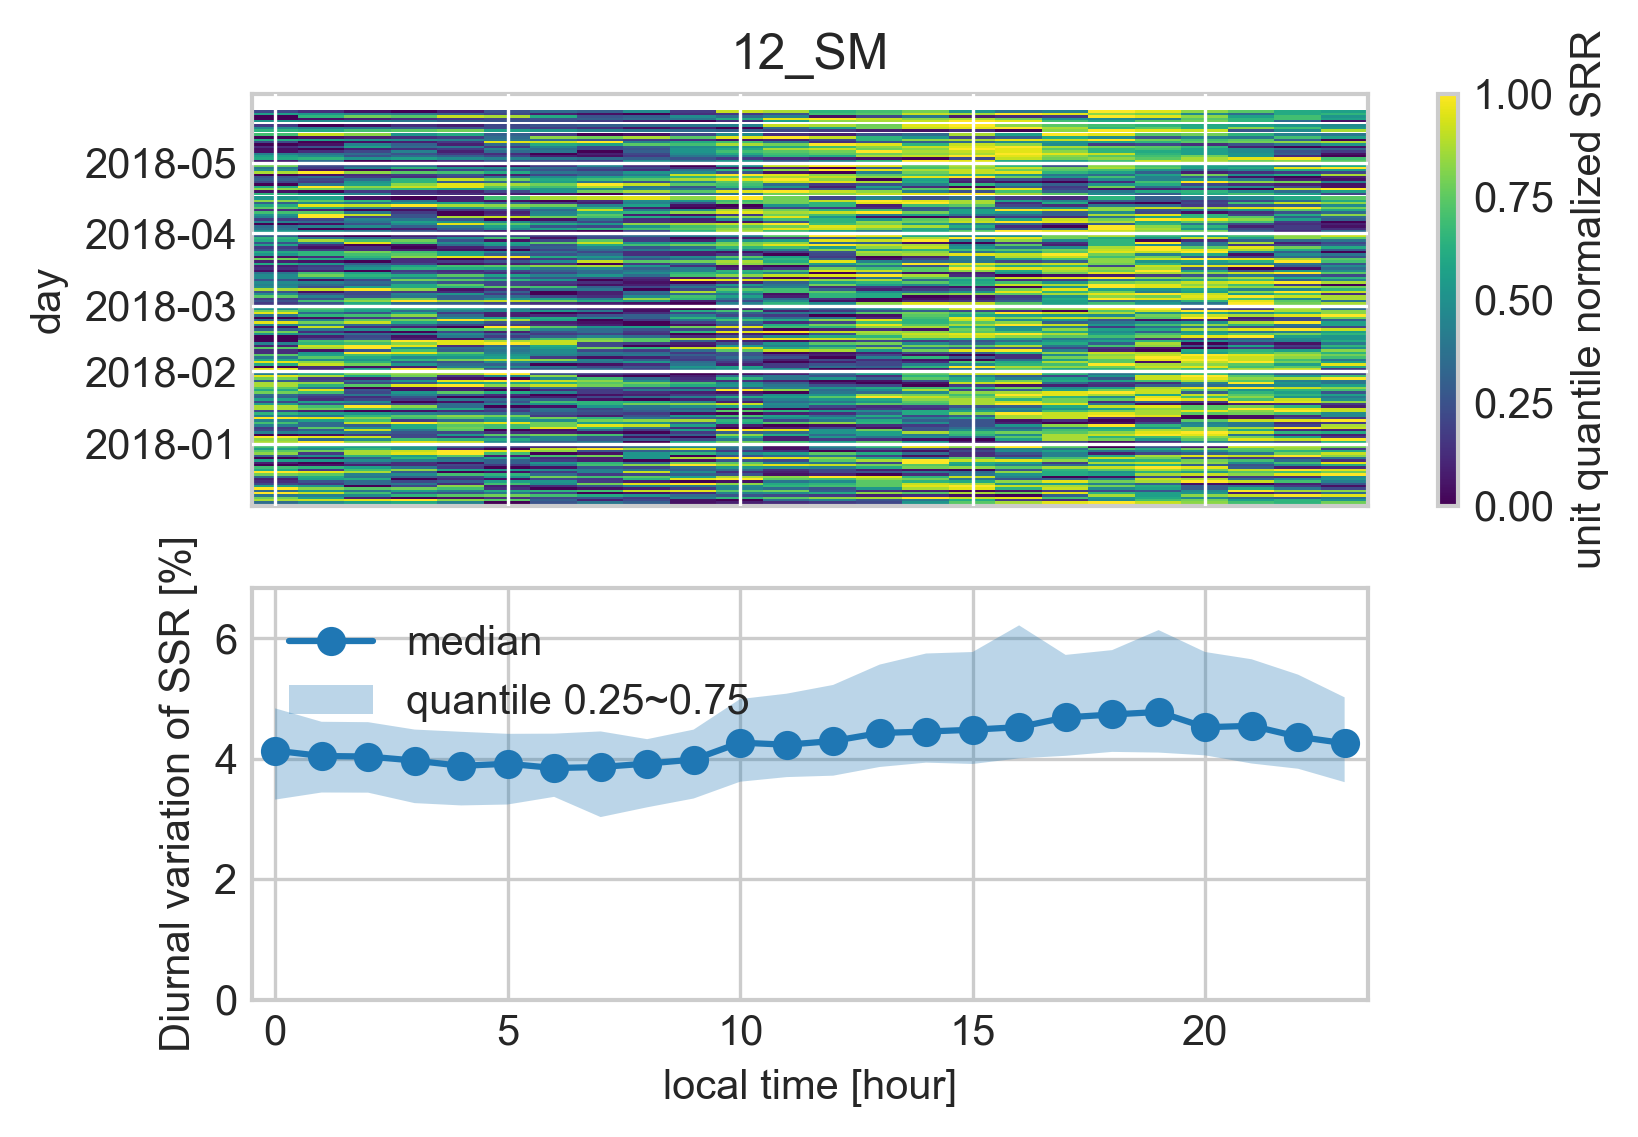

True     158
False     18
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


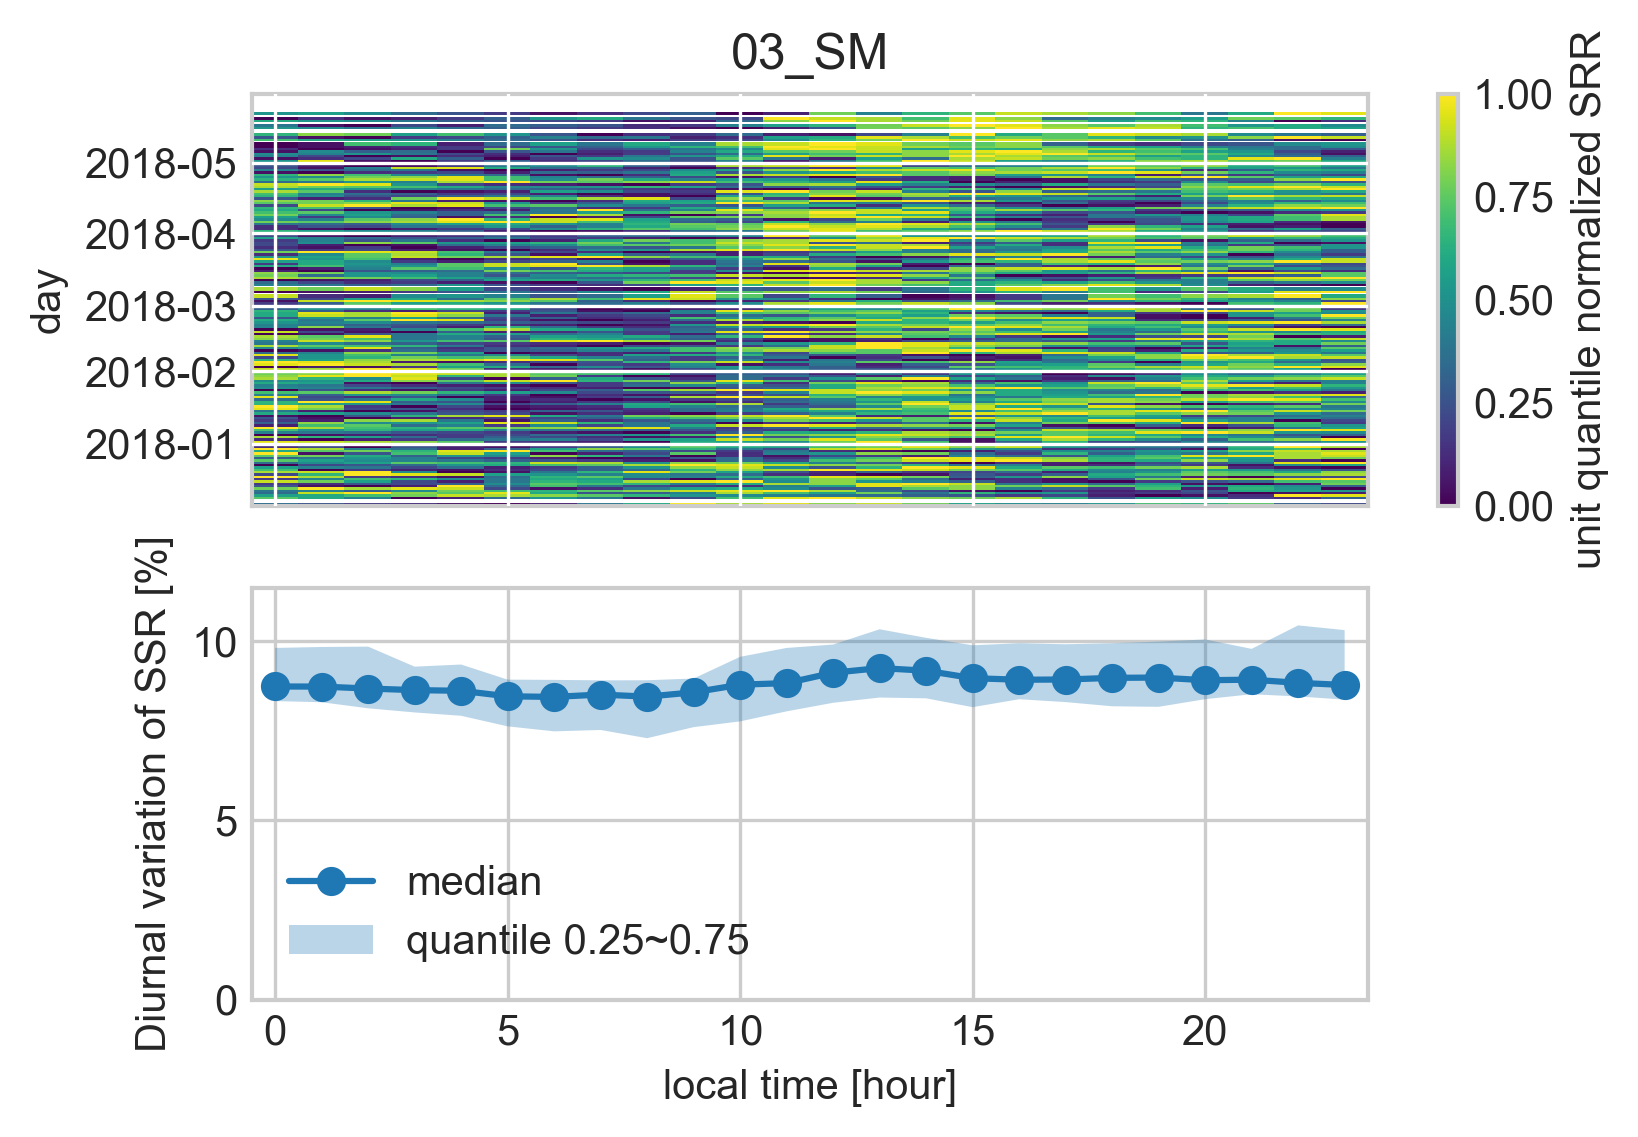

True     126
False     50
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


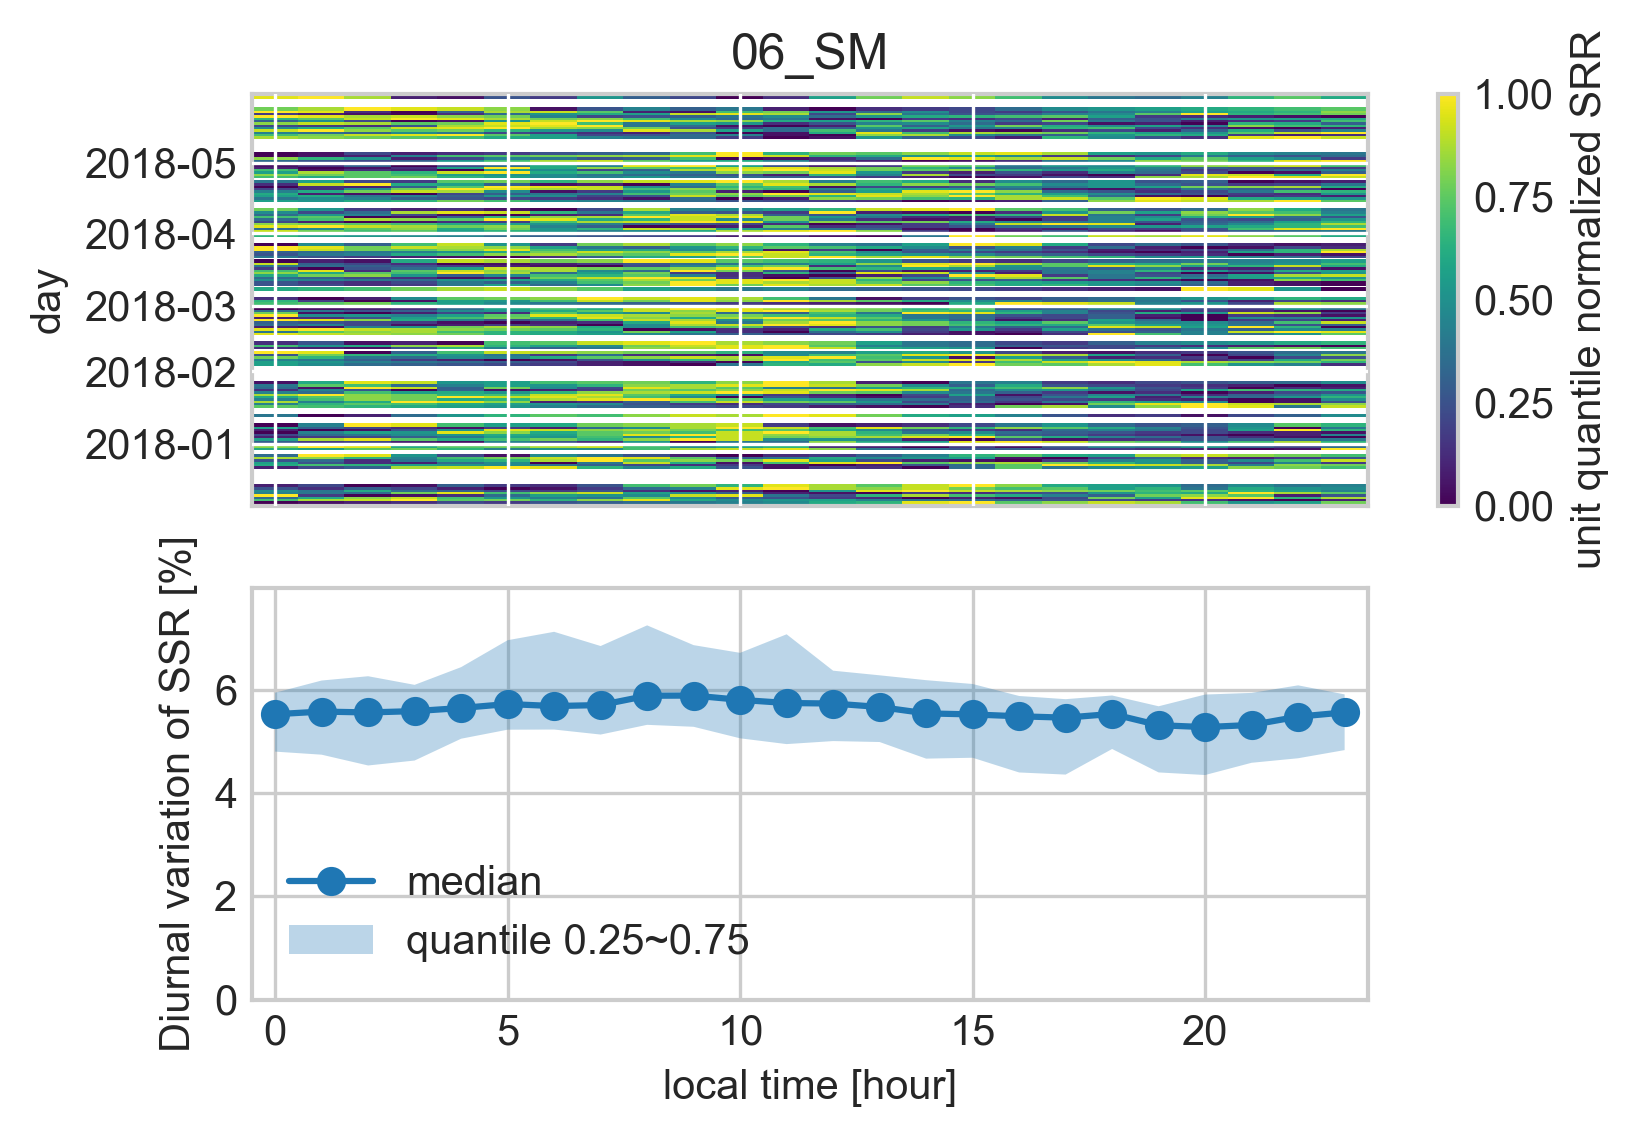

True     128
False     48
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


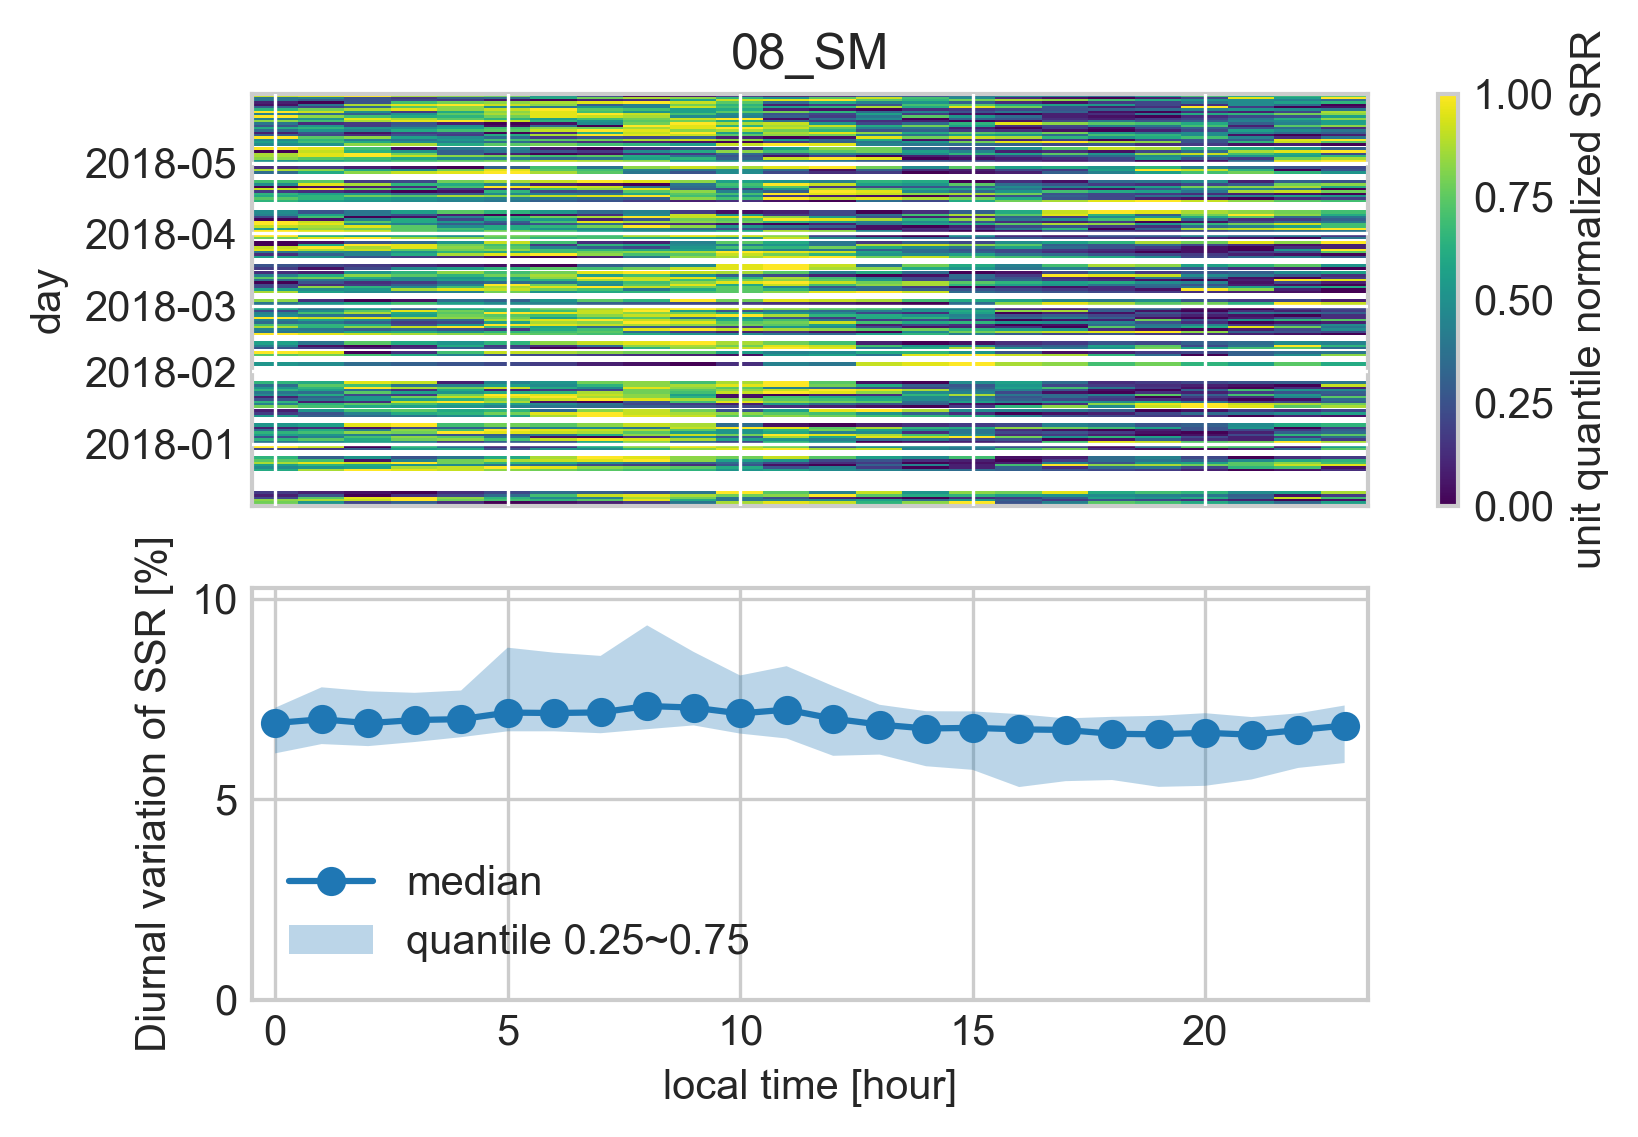

True     119
False     57
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


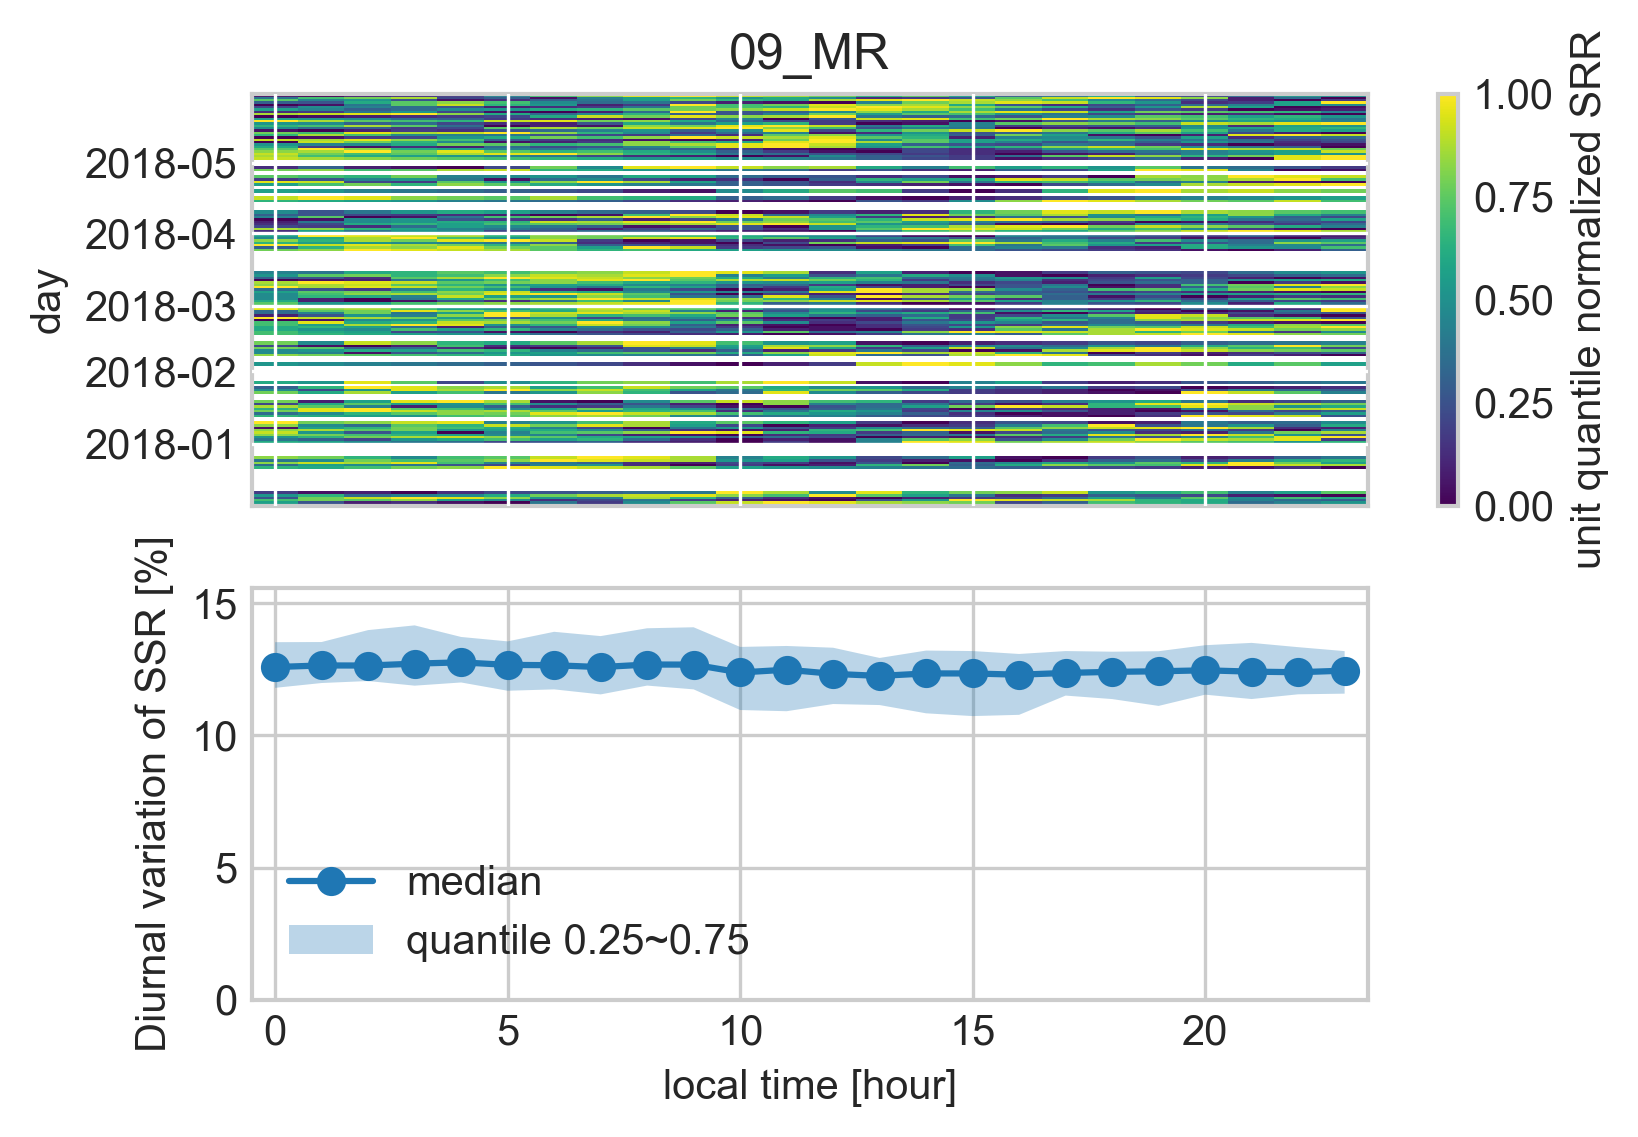

True     145
False     31
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


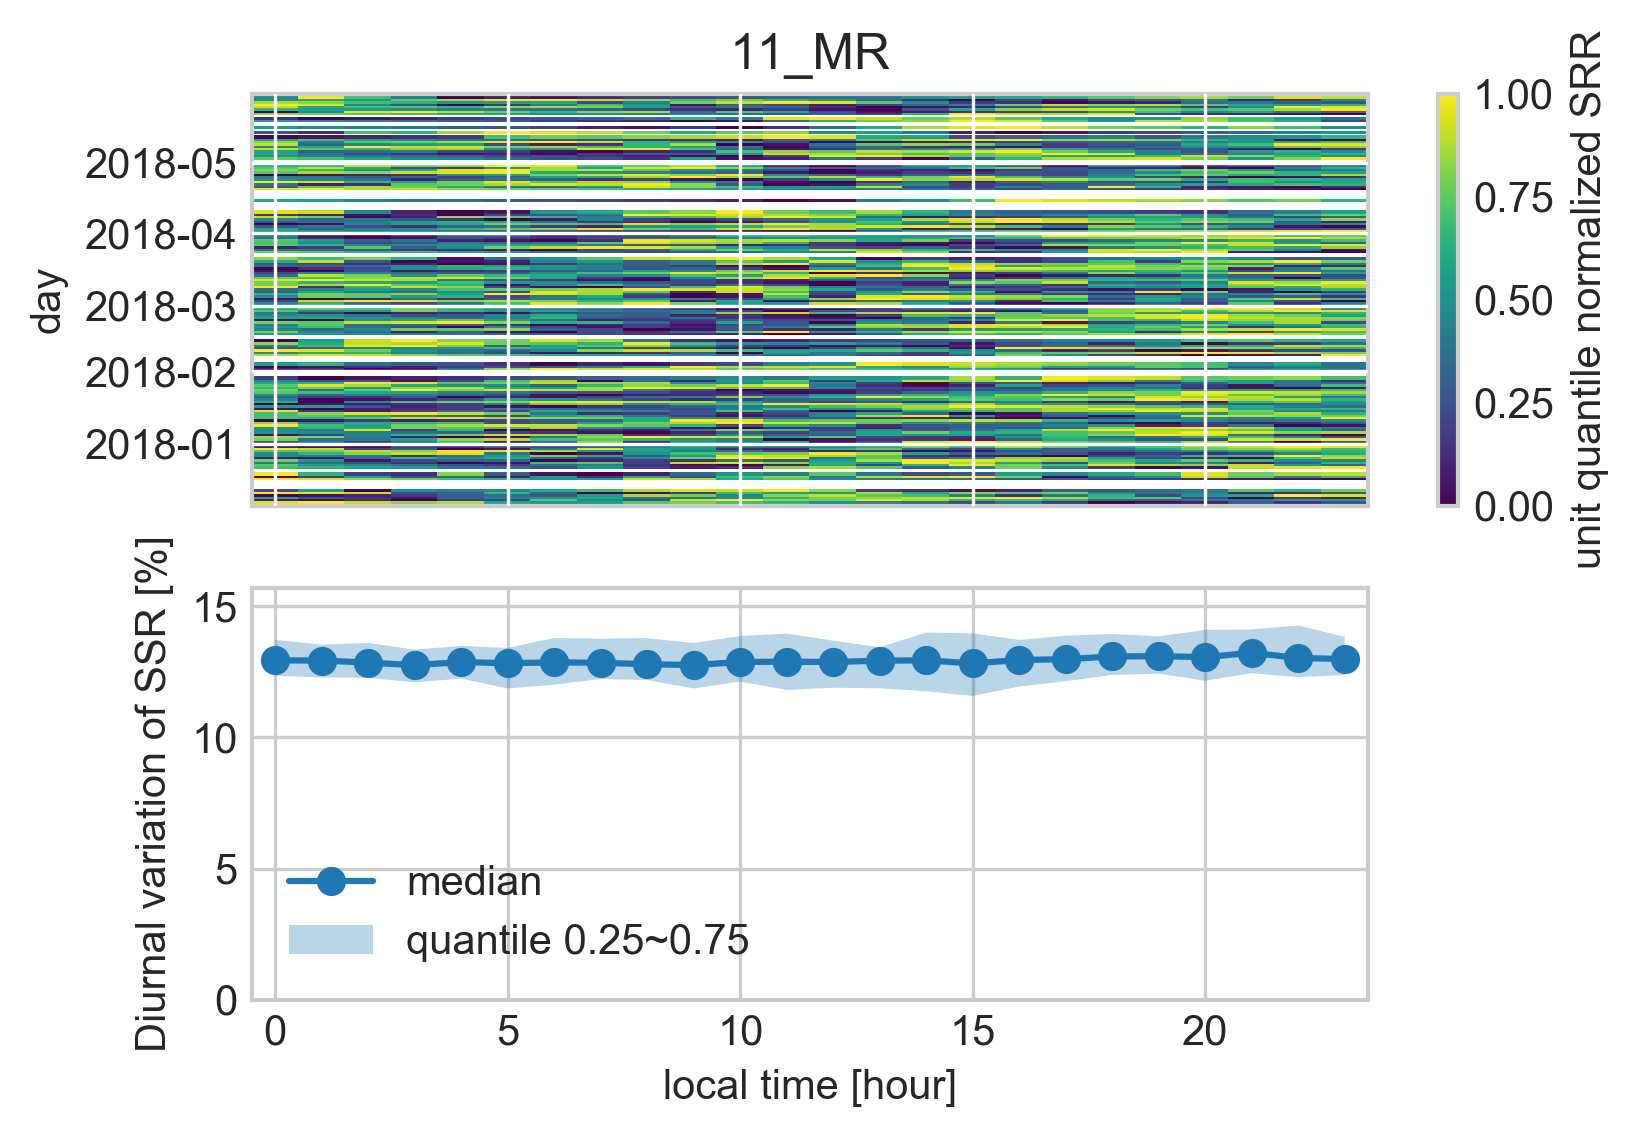

True     122
False     54
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


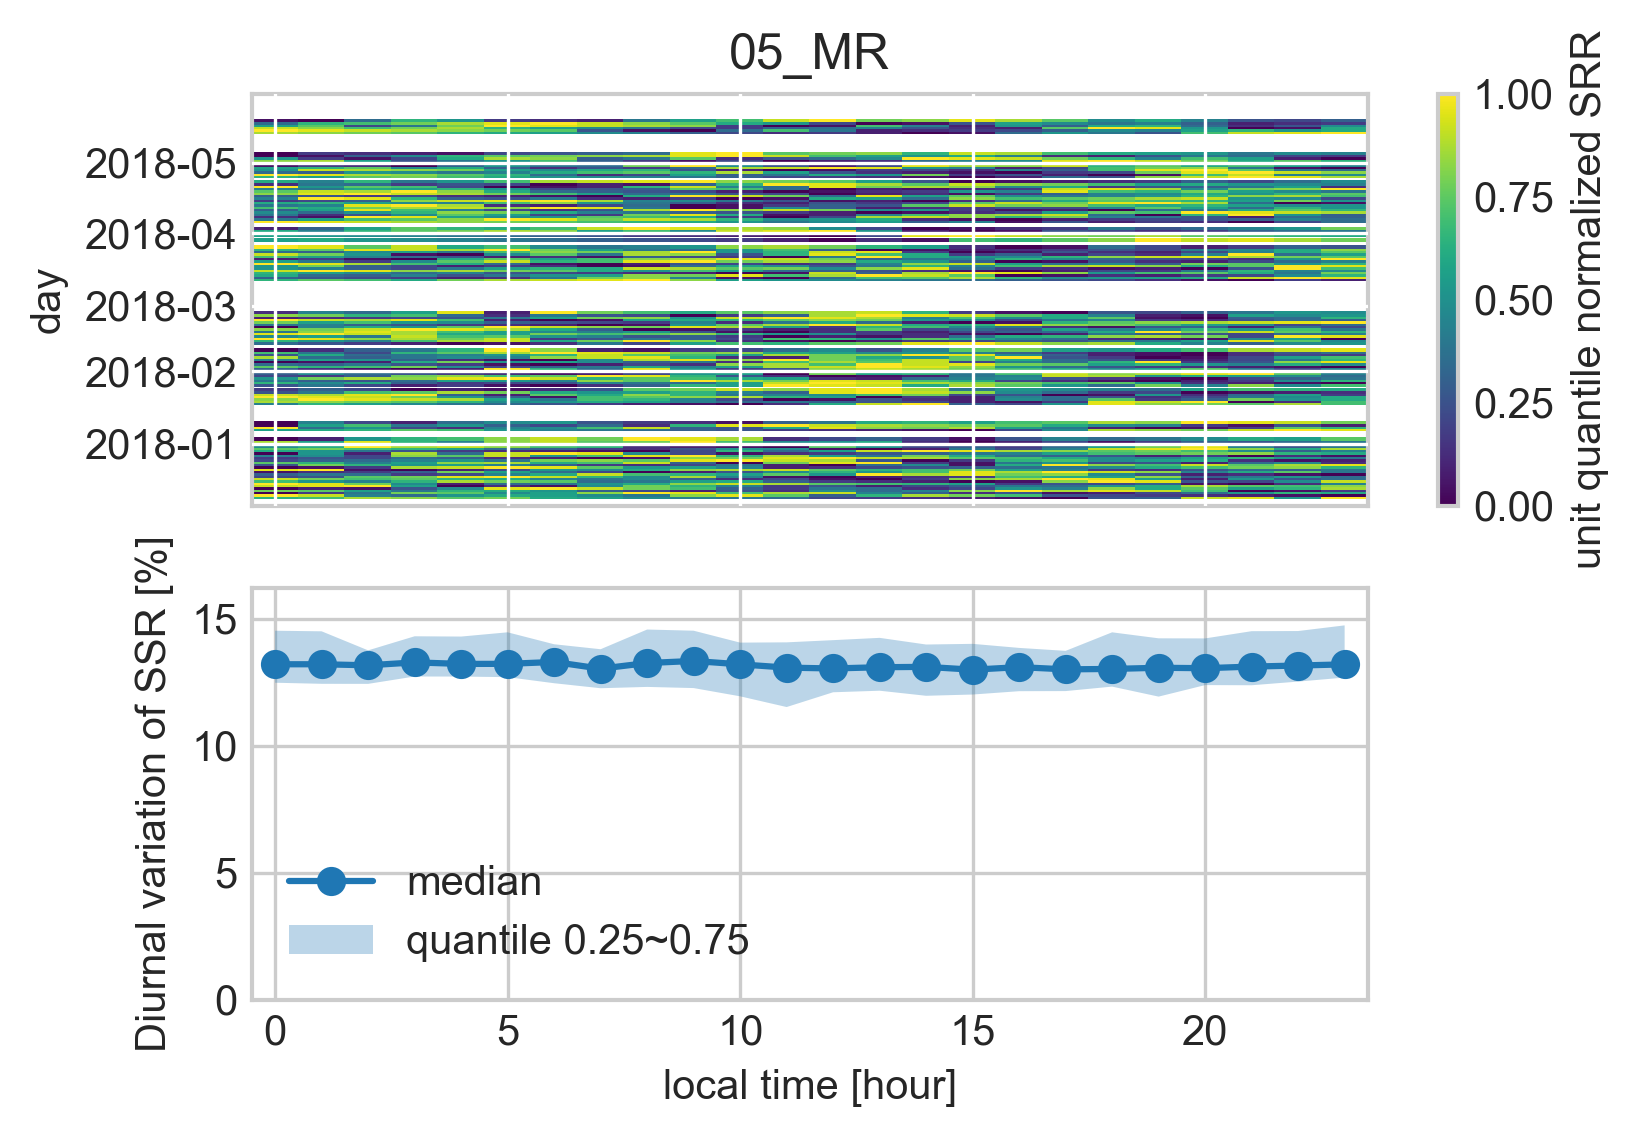

True     124
False     52
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


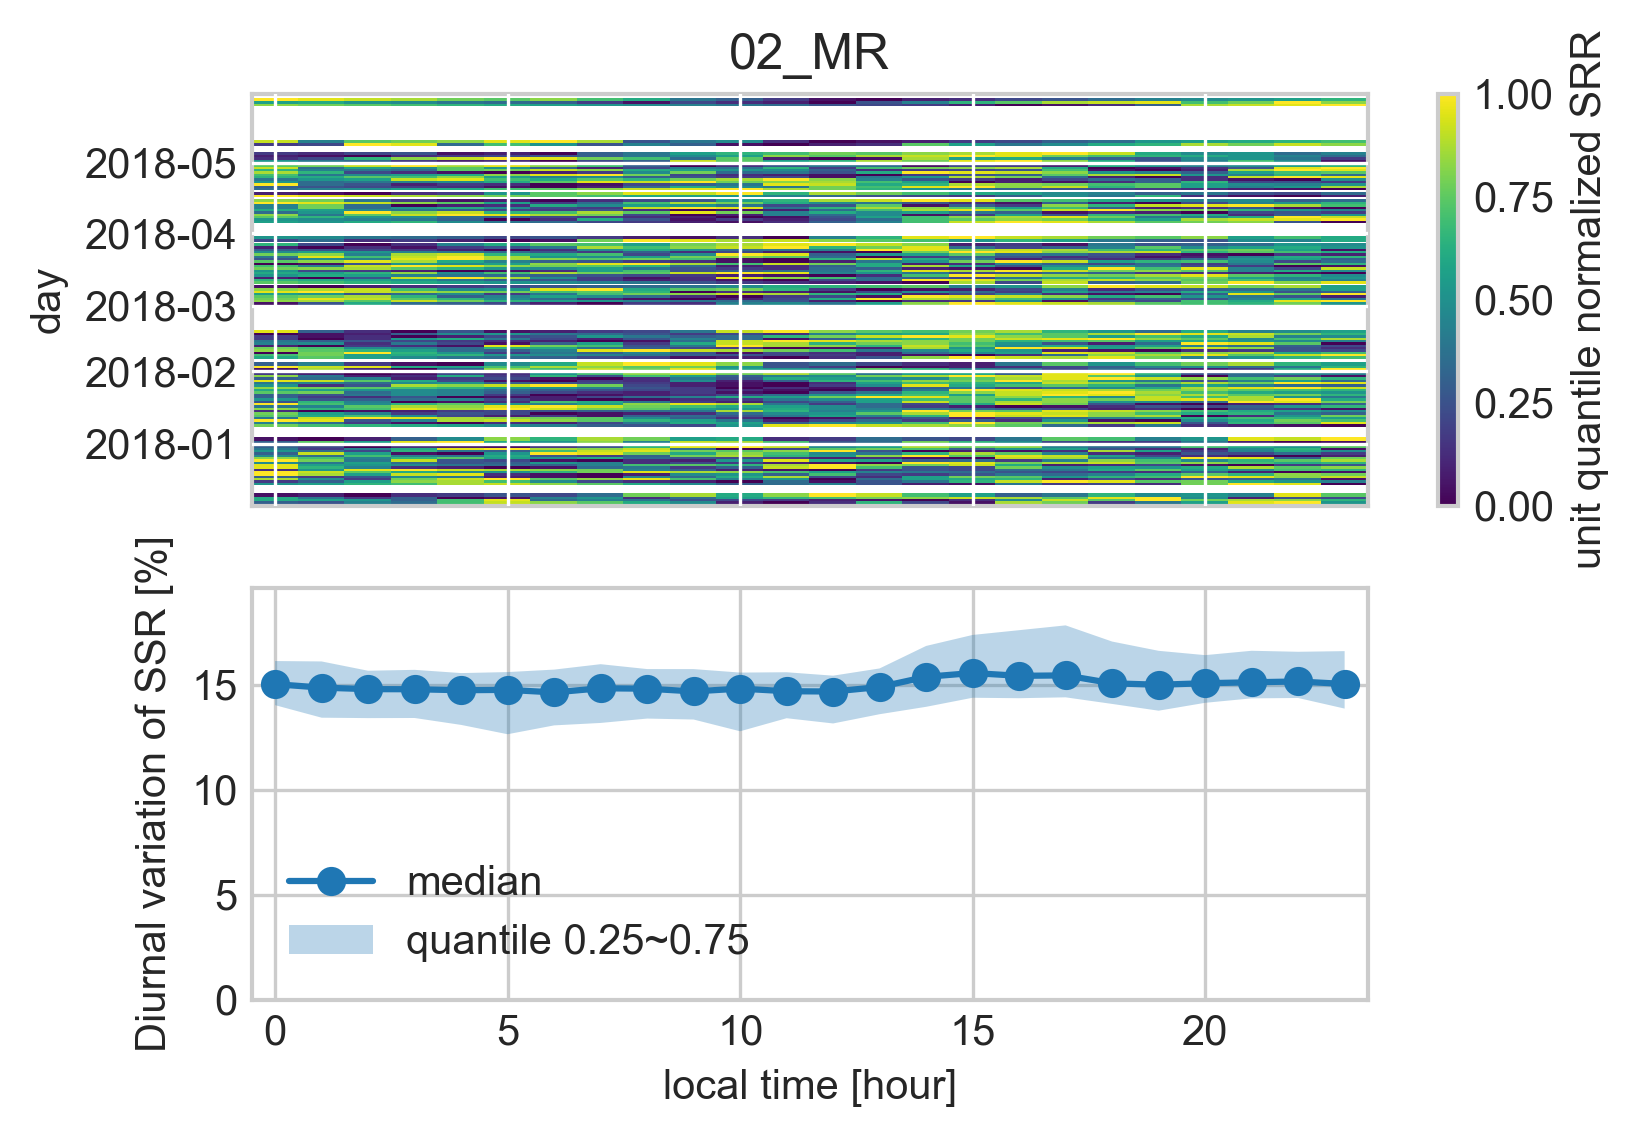

True     103
False     73
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


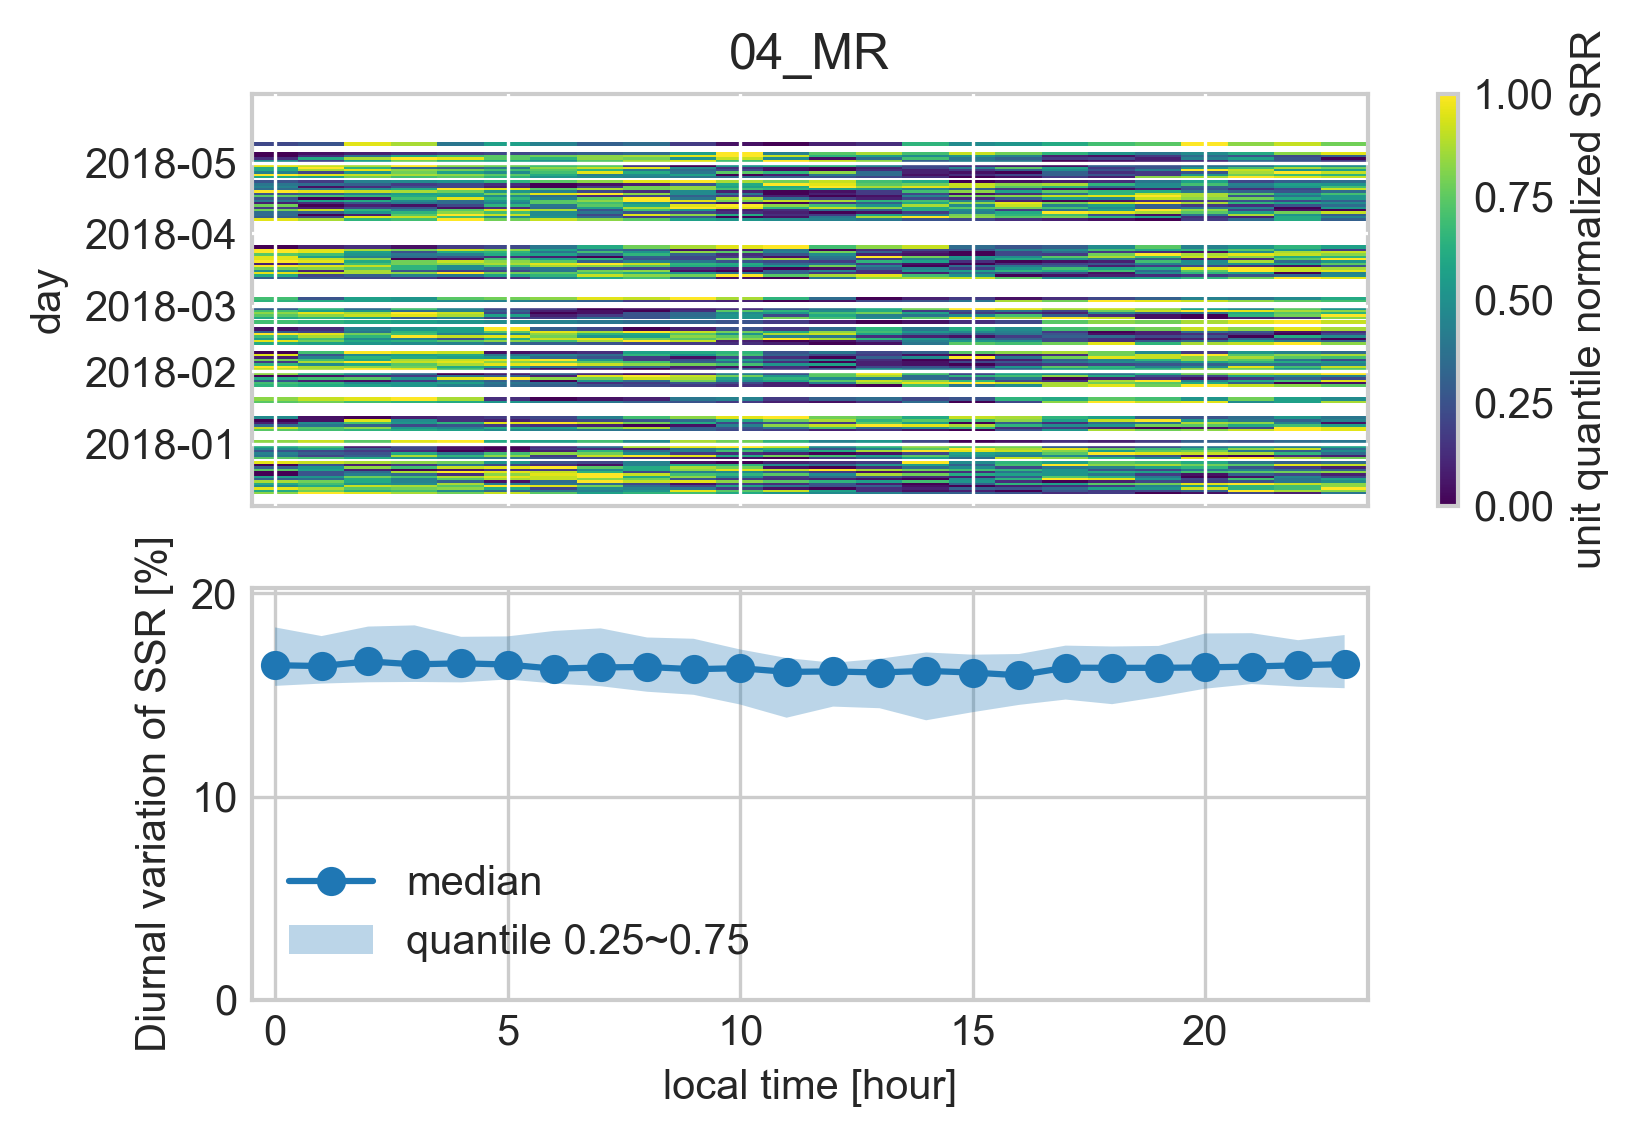

True     124
False     52
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


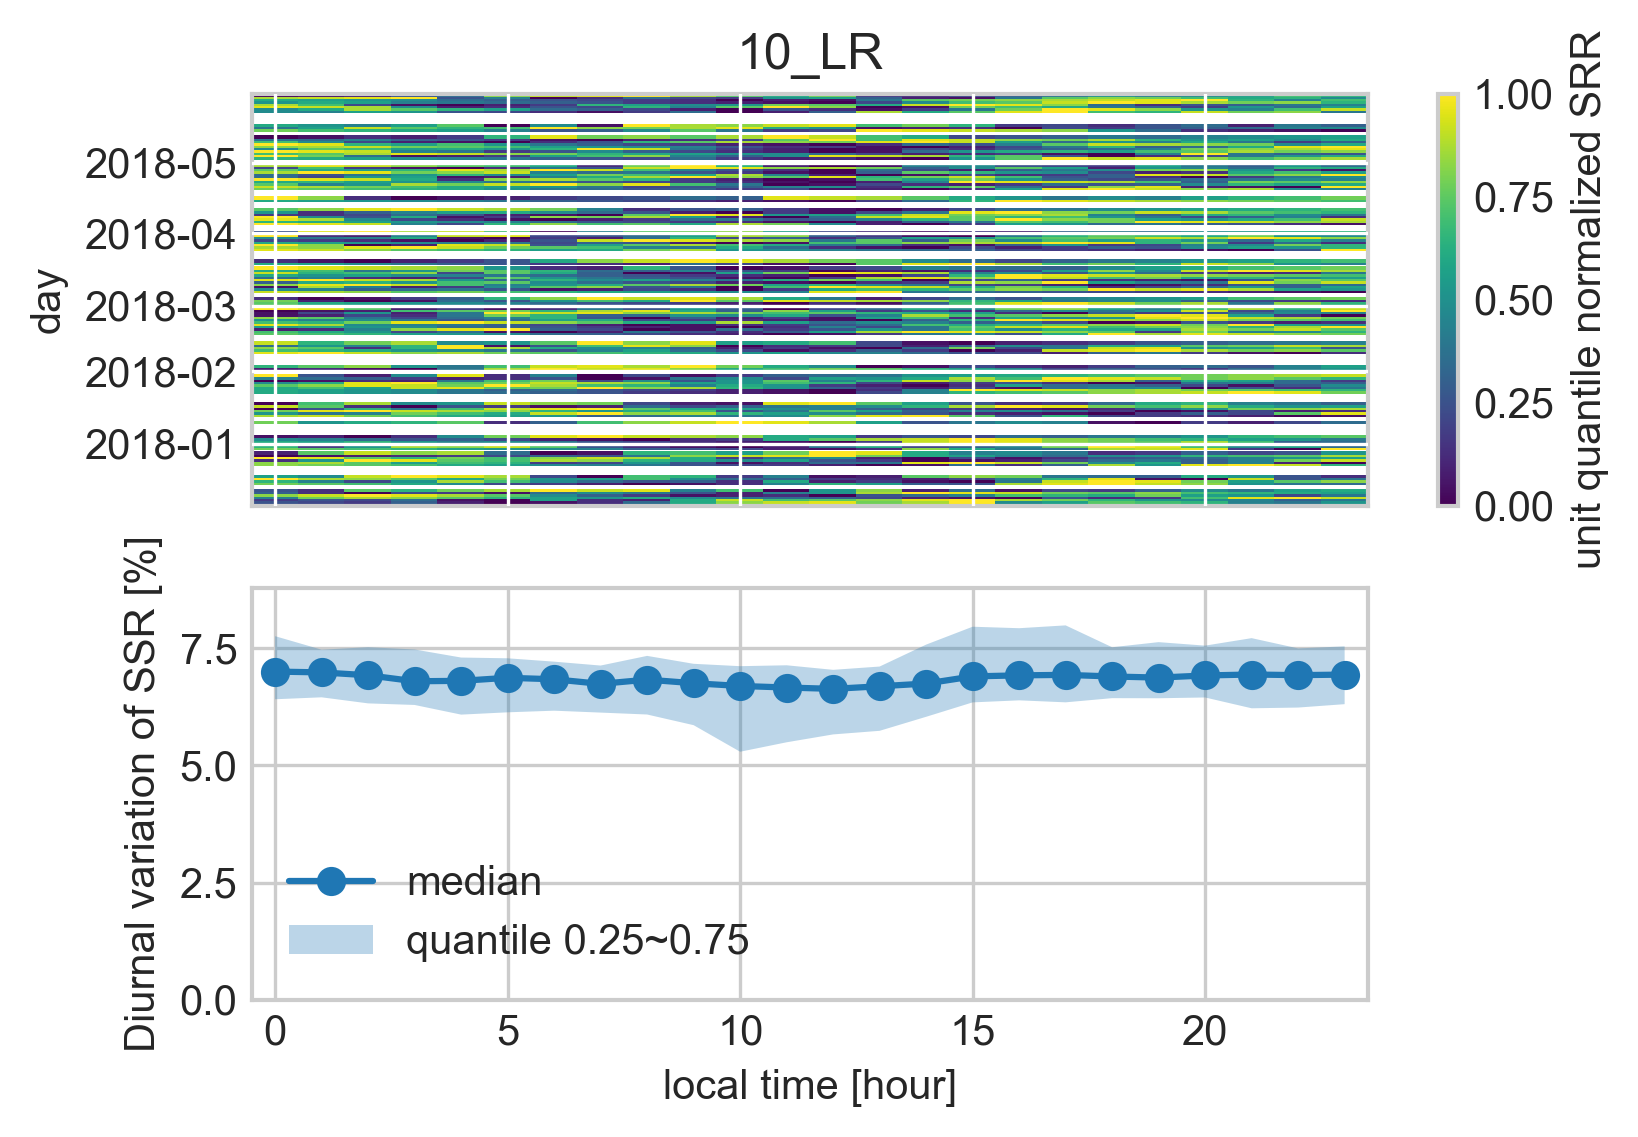

True     119
False     57
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


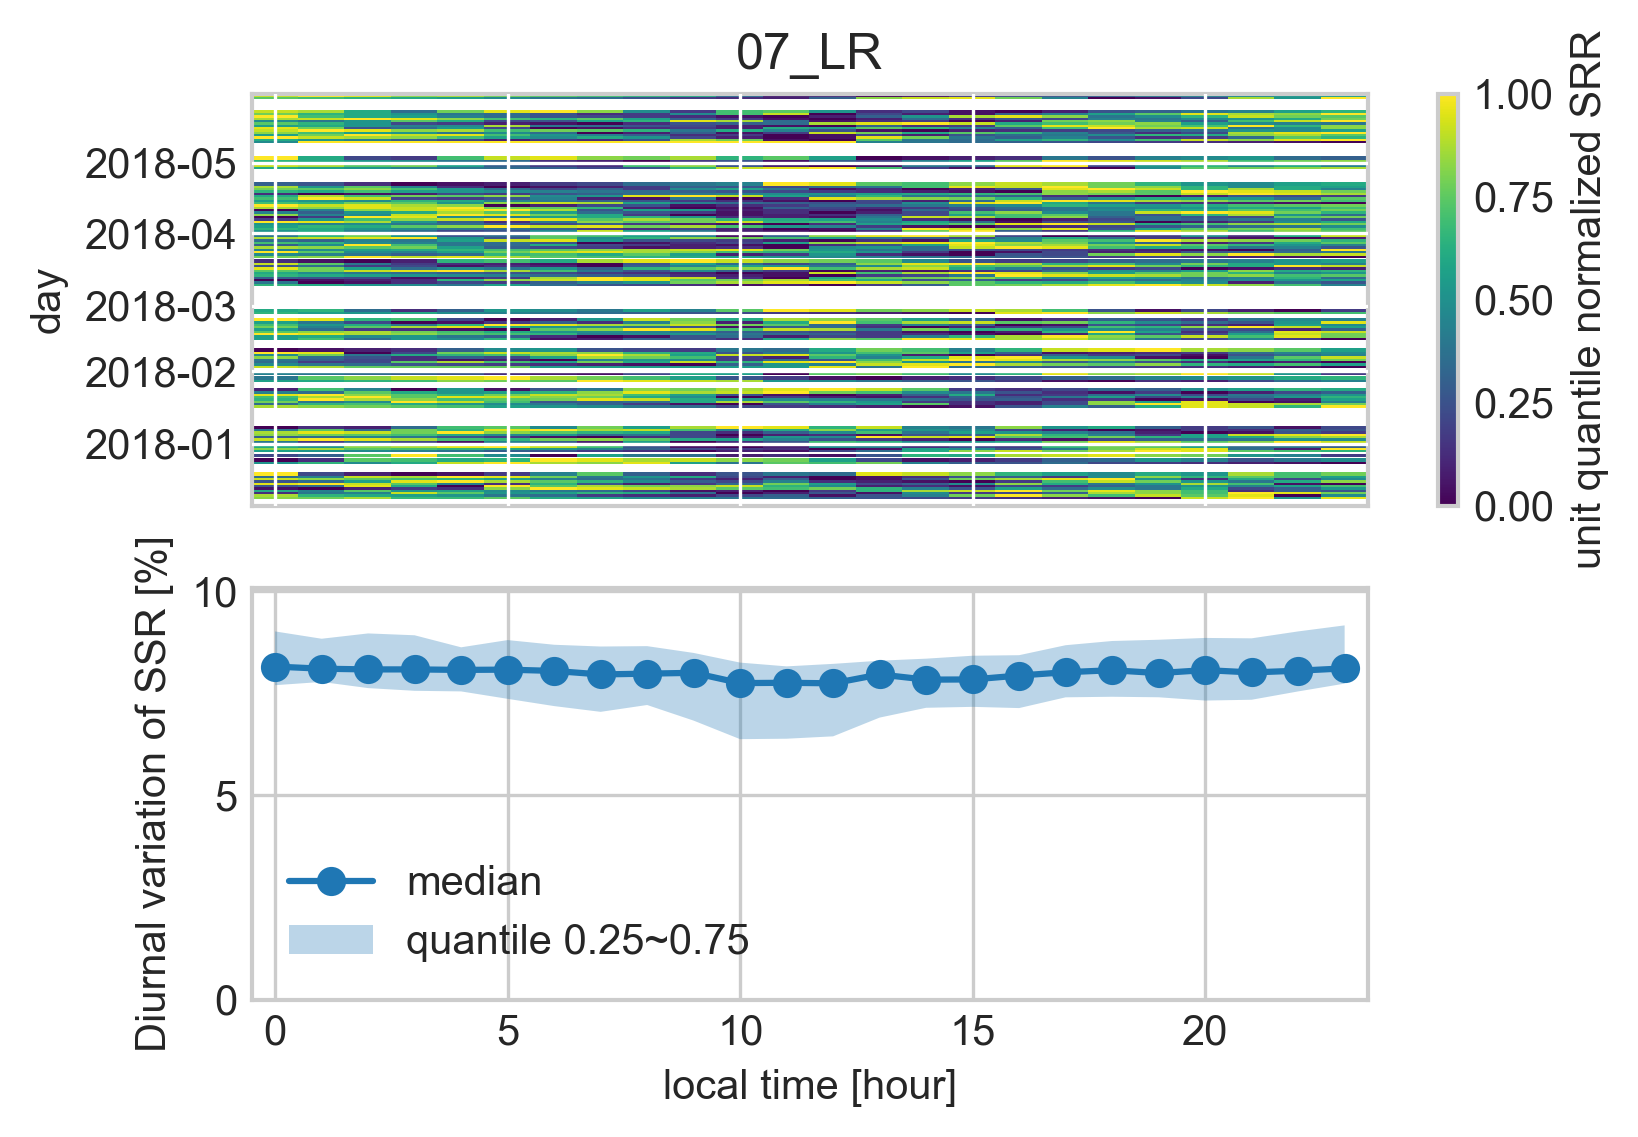

True     122
False     54
Name: conc_detrended, dtype: int64


/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


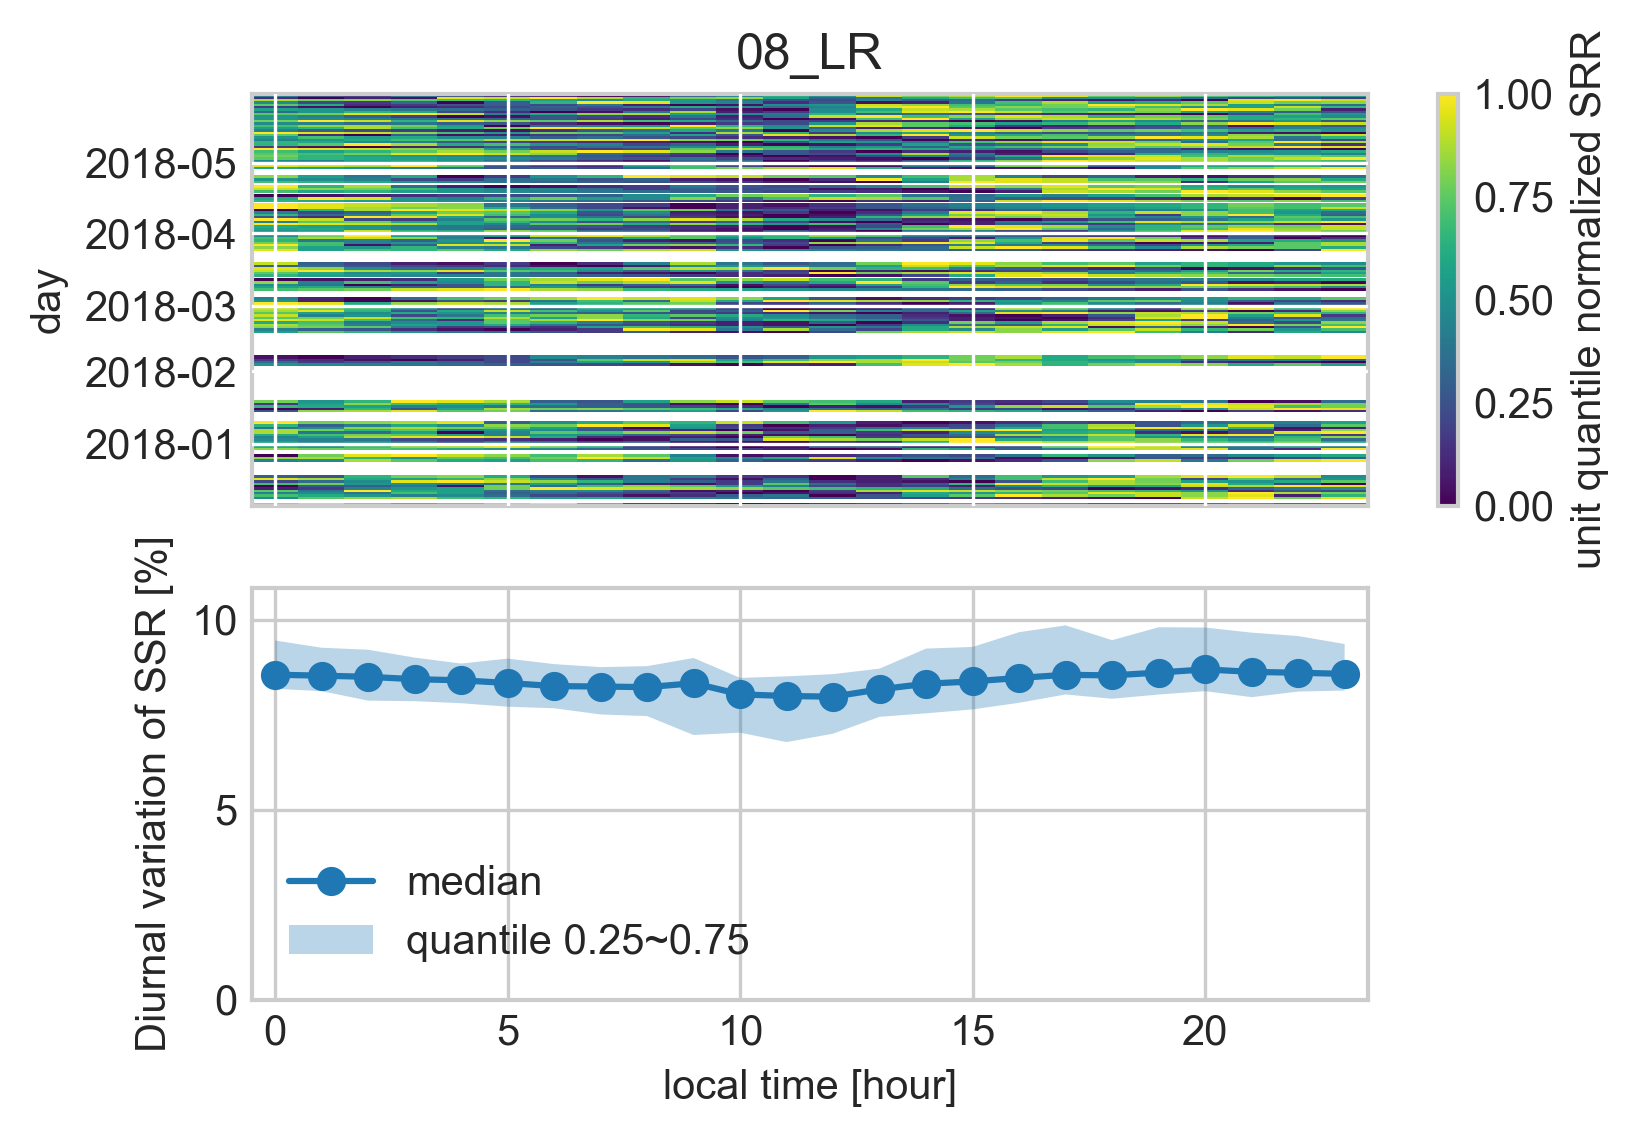

In [29]:

main()